107062634 林奕廷<br>
104062522 吳家承<br>
106024518 張家豪<br>

In [1]:
# import the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=8,suppress=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [2]:
# function used to draw a sketch
def get_bounds(data, factor=10):
  """Return bounds of data."""
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0

  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
  return (min_x, max_x, min_y, max_y)


def draw_strokes(data,
                 svg_filename='/tmp/sketch_rnn/svg/sample.svg',
                 factor=0.2,
                 show_pen_sequence=False,
                 who_draw_the_stroke=None):
  if not os.path.exists(os.path.dirname(svg_filename)):
    os.makedirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "M"
  xs = []
  ys = []
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "M"
    elif (command != "L"):
      command = "L"
    else:
      command = ""
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    xs.append(abs_x)
    ys.append(abs_y)
    lift_pen = data[i, 2]
    p += command + str(abs_x) + "," + str(abs_y) + " "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
  color = 'black'
  if show_pen_sequence:
    turn = 0
    for i in range(1, len(xs)):
      dwg.add(
          dwg.text(
              '{}'.format(i),
              insert=(xs[i], ys[i]),
              font_size="10px",
              fill=color))
      if who_draw_the_stroke is not None:
        if data[i, 2] == 1:
          color = 'red' if who_draw_the_stroke[turn] == 0 else 'black'
          turn += 1
  display(SVG(dwg.tostring()))

In [3]:
# load data
data = np.load('../../lab231/contest5_data/light bulb.full.npz', encoding = "bytes")
train_sketches = data['train']
valid_sketches = data['valid']
test_sketches = data['test']
print('num train: {}'.format(len(train_sketches)))
print('num valid: {}'.format(len(valid_sketches)))
print('num test: {}'.format(len(test_sketches)))

num train: 104447
num valid: 2500
num test: 2500


In [4]:
def preprocess(sketches, limit=1000):
  raw_data = []
  seq_len = []
  count_data = 0

  for i in range(len(sketches)):
    data = sketches[i]
    count_data += 1
    # removes large gaps from the data
    data = np.minimum(data, limit)
    data = np.maximum(data, -limit)
    data = np.array(data, dtype=np.float32)
    raw_data.append(data)
    seq_len.append(len(data))
  seq_len = np.array(seq_len)  # nstrokes for each sketch
  idx = np.argsort(seq_len)
  sketches = []
  for i in range(len(seq_len)):
    sketches.append(raw_data[idx[i]])
  return raw_data


def normalize(sketches):
  """Normalize entire dataset (delta_x, delta_y) to [-1,1]."""
  result = []
  for i in range(len(sketches)):
    tmp = sketches[i]
    sketches[i][:, :2] /= np.max(np.abs(sketches[i][:, :2]))
    result.append(tmp)
  return result


def to_big_strokes(strokes):
  """Converts from stroke-3 to stroke-5 format and pads to given length, but does not insert special start token)."""

  result = np.zeros((len(strokes), 5), dtype=float)
  l = len(strokes)
  result[0:l, 0:2] = strokes[:, 0:2]
  result[0:l, 3] = strokes[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result


def to_big_sketches(sketches):
  result = []
  for i in range(len(sketches)):
    sketch = to_big_strokes(sketches[i])
    result.append(sketch)
  return result


def to_normal_strokes(big_strokes):
  """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
  l = 0
  for i in range(len(big_strokes)):
    if big_strokes[i, 4] > 0:
      l = i
      break
  if l == 0:
    l = len(big_strokes)
  result = np.zeros((l, 3))
  result[:, 0:2] = big_strokes[0:l, 0:2]
  result[:, 2] = big_strokes[0:l, 3]
  return result

In [5]:
# preprocess sketches
train_sketches = preprocess(train_sketches)
valid_sketches = preprocess(valid_sketches)
test_sketches = preprocess(test_sketches)

train_sketches = normalize(train_sketches)
valid_sketches = normalize(valid_sketches)
test_sketches = normalize(test_sketches)

# convert to stroke-5 format
train_sketches = to_big_sketches(train_sketches)
valid_sketches = to_big_sketches(valid_sketches)
test_sketches = to_big_sketches(test_sketches)

In [6]:
# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):

  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max + x_min) * 0.5
    return x_start - center_loc, x_end

  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0] * grid_space + grid_space * 0.5
    grid_x = grid_loc[1] * grid_space_x + grid_space_x * 0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x + loc_x
    new_y_pos = grid_y + loc_y
    result.append([new_x_pos - x_pos, new_y_pos - y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos + delta_pos[0]
    y_pos = new_y_pos + delta_pos[1]
  return np.array(result)

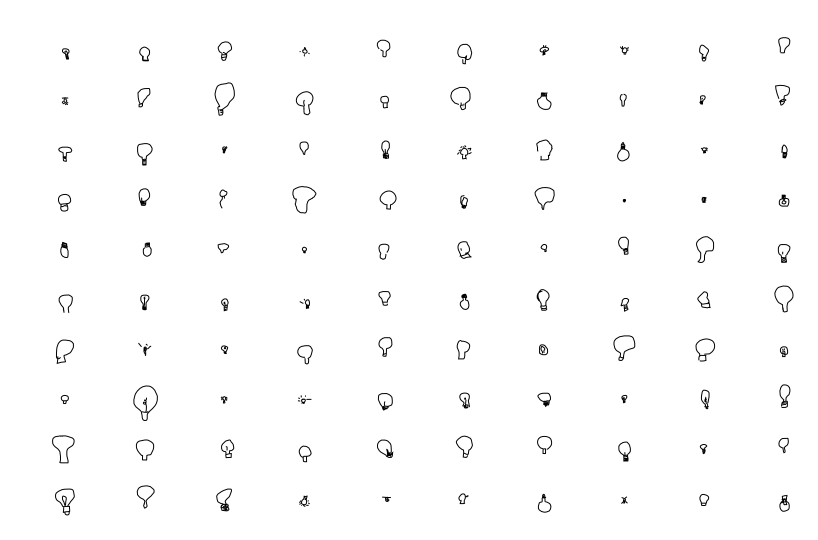

In [7]:
sketches_grid = []
for i in range(10):
  for j in range(10):
    sketches_grid.append(
        [to_normal_strokes(train_sketches[i * 10 + j]), [i, j]])
sketches_grid = make_grid_svg(sketches_grid)
draw_strokes(sketches_grid)

In [8]:
# import the required libraries
import time
import random
import json
import tensorflow as tf

In [9]:
# function used to generate next point
def adjust_temp(pi_pdf, temp):
  pi_pdf = np.log(pi_pdf) / temp
  pi_pdf -= pi_pdf.max()
  pi_pdf = np.exp(pi_pdf)
  pi_pdf /= pi_pdf.sum()
  return pi_pdf


def get_pi_idx(x, pdf, temp=1.0, greedy=False):
  """Samples from a pdf, optionally greedily."""
  if greedy:
    return np.argmax(pdf)
  pdf = adjust_temp(np.copy(pdf), temp)
  accumulate = 0
  for i in range(0, pdf.size):
    accumulate += pdf[i]
    if accumulate >= x:
      return i
  tf.logging.info('Error with sampling ensemble.')
  return -1


def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
  if greedy:
    return mu1, mu2
  mean = [mu1, mu2]
  s1 *= temp * temp
  s2 *= temp * temp
  cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
  x = np.random.multivariate_normal(mean, cov, 1)
  return x[0][0], x[0][1]

In [10]:
def find_true_len(input_tensor):
    true_len = []
    for i in range(input_tensor.shape[0]):
        cnt = 0
        for j in range(input_tensor[i][:,4].shape[0]):
            if input_tensor[i][:,4][j] == 0:
                cnt += 1
        true_len.append(cnt)
    
    return np.asarray(true_len)

In [11]:
class SRNN_Model():
  
    def __init__(self, hps, model_name='sketch_rnn'):
        self.hps = hps
        self.model_name=model_name
        with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
            self.build_model(hps)
    
    def build_model(self, hps):
      
        # input and output
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[], name='batch_size')
        self.input_sequence = tf.placeholder(dtype=tf.float32, shape=[None, hps.max_seq_len+1, 5], name='input_sequence')
        input_sequence = self.input_sequence[:, :-1]
        output_sequence = self.input_sequence[:, 1:, :]
        #self.max_len_arr = tf.placeholder(dtype=tf.int64, shape=[None], name='max_len_arr')
        #input_sequence_non_zero = tf.count_nonzero(self.input_sequence[:,:,:], 1)[:,4]
        #input_sequence_zero = tf.subtract(self.max_len_arr, input_sequence_non_zero)
        self.lstm_cell = tf.nn.rnn_cell.LSTMCell(hps.dec_rnn_size)
        self.zero_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        #output, _ = tf.nn.dynamic_rnn(self.lstm_cell, input_sequence, initial_state=self.zero_state, sequence_length = tf.constant(hps.max_seq_len, shape=[self.input_sequence.shape[0]], dtype = tf.int64) - tf.count_nonzero(self.input_sequence[:,:,:], 1)[:,4])
        output, _ = tf.nn.dynamic_rnn(self.lstm_cell, input_sequence, initial_state=self.zero_state, sequence_length = tf.count_nonzero(tf.equal(self.input_sequence[:,1:,4],tf.constant(0., dtype = tf.float32)),1))
        output = tf.reshape(output, [-1, hps.dec_rnn_size])
        
        # for each input timestamp, output parameters for mixture of gaussian
        num_hidden = hps.num_mixture * 6 + 3 
        def feed_forward(output):
            with tf.variable_scope('feed_forward', reuse=tf.AUTO_REUSE):
                return tf.layers.dense(output, num_hidden)
        output = feed_forward(output)
        ##############################################################################
        
        """
        Loss for mixture of multivariate gaussian. Given (prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
        we want the mixture to output high probility P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3),
        see equation (9) at https://arxiv.org/pdf/1704.03477.pdf
        
        parameters:
            pi: weight of each mixture, shape (batch_size*max_seq_len, num_mixture)
            mu1, mu2: mu of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            sigma1, sigma2: sigma of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            corr: correction of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
        """
        output_params = tf.split(output, num_or_size_splits=[3]+[hps.num_mixture]*6, axis=1)
        output_pen_logits, output_mixture_pi, output_mu1, output_mu2, output_sigma1, output_sigma2, output_corr = output_params
        
        # softmax all the pi's and pen states:
        output_mixture_pi = tf.nn.softmax(output_mixture_pi)
        output_pen_pi = tf.nn.softmax(output_pen_logits)
        
        # exponentiate the sigmas and also make corr between -1 and 1.
        output_sigma1 = tf.exp(output_sigma1)
        output_sigma2 = tf.exp(output_sigma2)
        output_corr = tf.tanh(output_corr)
        
        x1 = tf.reshape(output_sequence[:, :, 0], [-1, 1])
        x2 = tf.reshape(output_sequence[:, :, 1], [-1, 1])
        
        def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
            """
            Returns P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
            see equation (24) of http://arxiv.org/abs/1308.0850 or 
            https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
            """
            norm1 = tf.subtract(x1, mu1)
            norm2 = tf.subtract(x2, mu2)
            s1s2 = tf.multiply(s1, s2)
            # eq 25
            z = (tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2)) -
                 2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2))
            neg_rho = 1 - tf.square(rho) + 1e-6 # avoid divide by zero
            result = tf.exp(tf.div(-z, 2 * neg_rho))
            denom = 2 * np.pi * tf.multiply(s1s2, tf.sqrt(neg_rho))
            result = tf.div(result, denom)
            self.denom = denom
            self.neg_rho = neg_rho
            self.s1s2 = s1s2
            self.s1 = s1
            self.s2 = s2
            return result

        point_prob = tf_2d_normal(x1, x2, output_mu1, output_mu2, output_sigma1, output_sigma2, output_corr)
        point_prob = tf.multiply(point_prob, output_mixture_pi) # multiply weight of each mixture
        point_prob = tf.reduce_sum(point_prob, axis=1)
        
        # loss for indicating if pen should stop
        pen_labels = tf.reshape(output_sequence[:, :, 2:], [-1, 3]) # (batch_size*max_seq_len ,3)
        pen_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=pen_labels, logits=output_pen_logits)
        self.pen_loss = tf.reduce_mean(pen_loss)
        
        # loss for delta x,y
        delta_xy_loss = -tf.log(point_prob + 1e-6)  # avoid log(0)
        mask = 1.0 - pen_labels[:, 2]    
        mask = tf.reshape(mask, [-1, 1])        
        delta_xy_loss = delta_xy_loss * mask
        self.delta_xy_loss = tf.reduce_mean(delta_xy_loss)
        
        
        self.loss = self.pen_loss + self.delta_xy_loss

        # optimize rnn
        self.global_step = tf.get_variable(name='global_step', initializer=tf.constant(0), trainable=False)
        self.learning_rate = tf.get_variable(name='learning_rate', initializer=tf.constant(hps.learning_rate), trainable=False)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/')
        grad_vars = optimizer.compute_gradients(self.loss, var_list=var_list)
        grad_vars = [(tf.clip_by_value(grad, -hps.grad_clip, hps.grad_clip), var) for grad, var in grad_vars]
        self.train_op = optimizer.apply_gradients(grad_vars, global_step=self.global_step, name='train_step')
        
        #################### tensor for generating a point ############################
        self.prev_state = self.lstm_cell.zero_state(1, dtype=tf.float32)
        self.prev_point = tf.placeholder(tf.float32, shape=[1,5], name='prev_point')
        output, self.next_state = self.lstm_cell(self.prev_point, self.prev_state)
        output = tf.reshape(output, [-1, hps.dec_rnn_size])
        output = feed_forward(output)
        self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr = \
                                                              tf.split(output[:,3:], num_or_size_splits=6, axis=1)
        pen_logits = output[:,:3]
        self.output_pi = tf.nn.softmax(self.output_pi)
        self.pen_pi = tf.nn.softmax(pen_logits)
        self.output_sigma1 = tf.exp(self.output_sigma1)
        self.output_sigma2 = tf.exp(self.output_sigma2)
        self.output_corr = tf.tanh(self.output_corr)
        
    def generate_stroke(self, sess, prev_sketch, temperature = 0.1, greedy = False):
        """
        *****************************IMPORTANT*****************************
        1. your model must have this function, or error happen when evaluation.
        2. the length of stroke must less than 10, which means you can at most generate 10 points.
        *******************************************************************
        this function return a stroke given previous generated sketch
        """
        # feed previous sketch to get hidden state
        prev_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
        for i in range(len(prev_sketch)-1):
            feed_dict = {
                    self.prev_state: prev_state,
                    self.prev_point: [prev_sketch[i]]}
            prev_state = sess.run(self.next_state, feed_dict)
        
        # start to generate next stroke
        prev_point = [prev_sketch[-1]]
        generated_stroke = []
        while len(generated_stroke) < 10: 
            feed_dict = {
                self.prev_state: prev_state,
                self.prev_point: prev_point,
            }
            params = sess.run([
                self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr,
                self.pen_pi, self.next_state
            ], feed_dict)

            [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params
            
            # sample index of bivarite normal in mixture to use
            idx = get_pi_idx(np.random.random(), o_pi[0], temperature, greedy)
            
            # sample index of pen state
            idx_eos = get_pi_idx(np.random.random(), o_pen[0], temperature, greedy)
            eos = [0, 0, 0]
            eos[idx_eos] = 1

            # use one bivarite normal to generate next (delta_x, delta_y)
            next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                                  o_sigma1[0][idx], o_sigma2[0][idx],
                                                  o_corr[0][idx], np.sqrt(temperature), greedy)

            prev_point = np.zeros([1,5])
            prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
            prev_state = next_state
            generated_stroke.append(prev_point)
            
            # if this stroke stop
            if prev_point[0][4]==1:
                generated_stroke[-1][0][:2] = 0
            if prev_point[0][4]==1 or prev_point[0][3]==1:
                break
        # pen state should end with p2=1 or p3=1
        if generated_stroke[-1][0][2] == 1:
            generated_stroke[-1][0][2:] = [0.,1.,0.]
        return np.concatenate(generated_stroke, axis=0)    
  
    def generate_sketches(self, sess, num_generate, temperature, greedy=False):
        initial_point = np.array([[0.,0.,1.,0.,0.]])
        initial_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
        return_sketches = []
        for i in range(num_generate):
            sketch = [initial_point]
            prev_point = initial_point
            prev_state = initial_state
            for j in range(self.hps.max_seq_len):
                feed_dict = {
                    self.prev_state: prev_state,
                    self.prev_point: prev_point,
                }
                params = sess.run([
                    self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr,
                    self.pen_pi, self.next_state
                ], feed_dict)

                [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params
                idx = get_pi_idx(random.random(), o_pi[0], temperature, greedy)

                idx_eos = get_pi_idx(random.random(), o_pen[0], temperature, greedy)
                eos = [0, 0, 0]
                eos[idx_eos] = 1

                next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                                      o_sigma1[0][idx], o_sigma2[0][idx],
                                                      o_corr[0][idx], np.sqrt(temperature), greedy)

                prev_point = np.zeros([1,5])
                prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
                prev_state = next_state
                
                # select a multivariate normal in mixture to draw next point
                sketch.append(prev_point)
                if prev_point[0][4]==1:
                    sketch[-1][0][:2] = 0
                    break
            return_sketches.append(np.concatenate(sketch, axis=0))
        return return_sketches
  
    def train(self, sess, x_train, x_valid, x_test, num_epoch=100, batch_size=100, patience = 20):
        start = time.time()
        best_valid_cost = np.inf
        counter = 0
        tf.constant
        for epoch in range(num_epoch):
            def gen_batch(x):
                shuffle_idx = np.random.permutation(len(x))
                x = x[shuffle_idx]
                num_batch = len(x)//batch_size
                for i in range(num_batch):
                    yield x[i*batch_size:(i+1)*batch_size]
            losses = []
            delta_xy_losses = []
            pen_losses = []
            for x_batch in gen_batch(x_train):
                step = sess.run(self.global_step)
                curr_learning_rate = ((hps.learning_rate - hps.min_learning_rate) *
                                      (hps.decay_rate)**step + hps.min_learning_rate)    
                feed_dict = {
                    self.input_sequence: x_batch,
                    self.learning_rate: curr_learning_rate,
                    self.batch_size: len(x_batch)
                }
                (loss, delta_xy_loss, pen_loss, _) = sess.run([self.loss, self.delta_xy_loss, 
                                                               self.pen_loss, self.train_op], feed_dict)
                losses.append(loss)
                delta_xy_losses.append(delta_xy_loss)
                pen_losses.append(pen_loss)
                if step % 20 == 0 and step > 0:
                    end = time.time()
                    time_taken = end - start
                    tf.logging.info(('step: {}, learning_rate: {:.4f}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                     'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, curr_learning_rate, 
                                      np.mean(losses), np.mean(delta_xy_losses), np.mean(pen_losses), time_taken))
                    losses = []
                    delta_xy_losses = []
                    pen_losses = []
                    start = time.time()
                if step % 1000 == 0 and step > 0:
                    N = 10
                    sketches = self.generate_sketches(sess, num_generate=N, temperature=0.5)
                    reconstructions = []
                    for i in range(N):
                        reconstructions.append([to_normal_strokes(sketches[i]), [0, i]])
                    stroke_grid = make_grid_svg(reconstructions)
                    draw_strokes(stroke_grid)

                if step % self.hps.save_every == 0 and step > 0:
                    start = time.time()
                    test_losses = []
                    test_delta_xy_losses = []
                    test_pen_losses = []
                    for x_batch in gen_batch(x_valid):
                        feed_dict = {
                            self.input_sequence: x_batch,
                            self.batch_size: len(x_batch)
                        }

                        (loss, delta_xy_loss, pen_loss) = sess.run([self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
                        test_losses.append(loss)
                        test_delta_xy_losses.append(delta_xy_loss)
                        test_pen_losses.append(pen_loss)

                    end = time.time()
                    time_taken = end - start
                    tf.logging.info(('validation, step: {}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                     'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, np.mean(test_losses), 
                                      np.mean(test_delta_xy_losses), np.mean(test_pen_losses), time_taken))                    
                    start = time.time()

                    if np.mean(test_losses) < best_valid_cost:
                        best_valid_cost = np.mean(test_losses)
                        #self.save_model(sess, step=step)
                        self.save_model(sess)
                        test_losses = []
                        test_delta_xy_losses = []
                        test_pen_losses = []
                        for x_batch in gen_batch(x_test):
                            feed_dict = {
                                self.input_sequence: x_batch,
                                self.batch_size: len(x_batch)
                            }

                            (loss, delta_xy_loss, pen_loss) = sess.run([self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
                            test_losses.append(loss)
                            test_delta_xy_losses.append(delta_xy_loss)
                            test_pen_losses.append(pen_loss)

                        end = time.time()
                        time_taken = end - start
                        tf.logging.info(('testing, step: {}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                         'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, np.mean(test_losses), 
                                          np.mean(test_delta_xy_losses), np.mean(test_pen_losses), time_taken))
                        counter = 0
                    else:
                        counter += 1
                        if counter > patience:
                            tf.logging.info('early stop!!')
                            return
                          
    def save_model(self, sess, checkpoint_dir='./checkpoints_v2',step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/'))
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, self.model_name), global_step=step)
            tf.logging.info('model save to {}-{}'.format(os.path.join(checkpoint_dir, self.model_name), step))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, self.model_name))
            tf.logging.info('model save to {}'.format(os.path.join(checkpoint_dir, self.model_name)))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', step=None):
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/'))
        if step is not None:
            saver.restore(sess, os.path.join(checkpoint_dir, self.model_name+'-{}'.format(step)))
        else:
            saver.restore(sess, os.path.join(checkpoint_dir, self.model_name))
            

In [12]:
def pad_data(sketches, max_seq_len):
  """Pad the batch to be stroke-5 bigger format as described in paper."""
  result = np.zeros((len(sketches), max_seq_len + 1, 5), dtype=float)
  for i in range(len(sketches)):
    l = len(sketches[i])
    result[i, 0:l, :] = sketches[i][:, :]
    result[i, l:, 4] = 1

    # put in the first token, as described in sketch-rnn methodology
    result[i, 1:, :] = result[i, :-1, :]
    result[i, 0, :] = 0
    result[i, 0, 2] = 1  # setting S_0 from paper.
  return result


def get_max_len(sketches):
  """Return the maximum length of an array of strokes."""
  max_len = 0
  for sketch in sketches:
    ml = len(sketch)
    if ml > max_len:
      max_len = ml
  return max_len

In [13]:
# get max sequence length and pad data
max_seq_len = get_max_len(train_sketches)
x_train = pad_data(train_sketches, max_seq_len)
x_valid = pad_data(valid_sketches, max_seq_len)
x_test = pad_data(test_sketches, max_seq_len)

In [14]:
def copy_hparams(hparams):
  """Return a copy of an HParams instance."""
  return tf.contrib.training.HParams(**hparams.values())


def get_default_hparams():
  """Return default HParams for sketch-rnn."""
  hparams = tf.contrib.training.HParams(
      data_set=['aaron_sheep.npz'],  # Our dataset.
      save_every=2000,  # Number of batches per checkpoint creation.
      max_seq_len=250,  # Not used. Will be changed by model. [Eliminate?]
      dec_rnn_size=1024,  # Size of decoder.
      batch_size=100,  # Minibatch size. Recommend leaving at 100.
      grad_clip=1.0,  # Gradient clipping. Recommend leaving at 1.0.
      num_mixture=20,  # Number of mixtures in Gaussian mixture model.
      learning_rate=0.0001,  # Learning rate.
      decay_rate=0.9999,  # Learning rate decay per minibatch.
      kl_decay_rate=0.99995,  # KL annealing decay rate per minibatch.
      min_learning_rate=0.00001,  # Minimum learning rate.
      use_recurrent_dropout=True,  # Dropout with memory loss. Recomended
      recurrent_dropout_prob=0.90,  # Probability of recurrent dropout keep.
      use_input_dropout=False,  # Input dropout. Recommend leaving False.
      input_dropout_prob=0.90,  # Probability of input dropout keep.
      use_output_dropout=False,  # Output droput. Recommend leaving False.
      output_dropout_prob=0.90,  # Probability of output dropout keep.
      random_scale_factor=0.15,  # Random scaling data augmention proportion.
      augment_stroke_prob=0.10,  # Point dropping augmentation proportion.
      conditional=True,  # When False, use unconditional decoder-only model.
      is_training=True  # Is model training? Recommend keeping true.
  )
  return hparams

In [15]:
hps = get_default_hparams()
hps.max_seq_len = max_seq_len

In [16]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
random.seed(123)
model = SRNN_Model(hps, model_name='team-31-bulb-microphone')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

INFO:tensorflow:step: 20, learning_rate: 0.0001, loss: 1.7584, xy_loss: 0.8607, pen_loss: 0.8977, time_taken: 2.08
INFO:tensorflow:step: 40, learning_rate: 0.0001, loss: 1.3636, xy_loss: 0.5998, pen_loss: 0.7638, time_taken: 1.49
INFO:tensorflow:step: 60, learning_rate: 0.0001, loss: 1.3036, xy_loss: 0.5545, pen_loss: 0.7492, time_taken: 1.49
INFO:tensorflow:step: 80, learning_rate: 0.0001, loss: 1.2679, xy_loss: 0.5291, pen_loss: 0.7387, time_taken: 1.50
INFO:tensorflow:step: 100, learning_rate: 0.0001, loss: 1.2594, xy_loss: 0.5204, pen_loss: 0.7390, time_taken: 1.49
INFO:tensorflow:step: 120, learning_rate: 0.0001, loss: 1.2160, xy_loss: 0.4925, pen_loss: 0.7235, time_taken: 1.51
INFO:tensorflow:step: 140, learning_rate: 0.0001, loss: 1.2093, xy_loss: 0.4789, pen_loss: 0.7303, time_taken: 1.49
INFO:tensorflow:step: 160, learning_rate: 0.0001, loss: 1.1653, xy_loss: 0.4447, pen_loss: 0.7206, time_taken: 1.49
INFO:tensorflow:step: 180, learning_rate: 0.0001, loss: 1.1496, xy_loss: 0.4

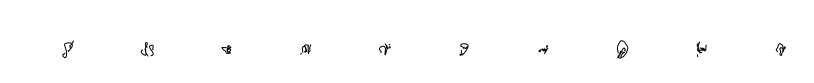

INFO:tensorflow:step: 1020, learning_rate: 0.0001, loss: 0.8504, xy_loss: 0.2143, pen_loss: 0.6361, time_taken: 4.43
INFO:tensorflow:step: 1040, learning_rate: 0.0001, loss: 0.8509, xy_loss: 0.2143, pen_loss: 0.6367, time_taken: 1.51
INFO:tensorflow:step: 1060, learning_rate: 0.0001, loss: 0.8248, xy_loss: 0.1916, pen_loss: 0.6332, time_taken: 1.64
INFO:tensorflow:step: 1080, learning_rate: 0.0001, loss: 0.8283, xy_loss: 0.2015, pen_loss: 0.6269, time_taken: 1.53
INFO:tensorflow:step: 1100, learning_rate: 0.0001, loss: 0.8257, xy_loss: 0.1970, pen_loss: 0.6287, time_taken: 1.52
INFO:tensorflow:step: 1120, learning_rate: 0.0001, loss: 0.8250, xy_loss: 0.1984, pen_loss: 0.6266, time_taken: 1.50
INFO:tensorflow:step: 1140, learning_rate: 0.0001, loss: 0.8377, xy_loss: 0.2077, pen_loss: 0.6300, time_taken: 1.52
INFO:tensorflow:step: 1160, learning_rate: 0.0001, loss: 0.8105, xy_loss: 0.1911, pen_loss: 0.6195, time_taken: 1.53
INFO:tensorflow:step: 1180, learning_rate: 0.0001, loss: 0.8278,

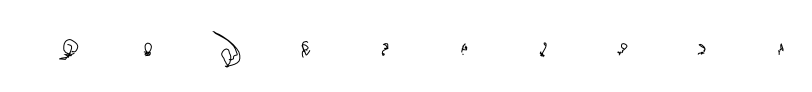

INFO:tensorflow:validation, step: 2000, loss: 0.6819, xy_loss: 0.1087, pen_loss: 0.5732, time_taken: 0.86
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 2000, loss: 0.6792, xy_loss: 0.1079, pen_loss: 0.5713, time_taken: 0.87
INFO:tensorflow:step: 2020, learning_rate: 0.0001, loss: 0.6845, xy_loss: 0.1124, pen_loss: 0.5721, time_taken: 2.38
INFO:tensorflow:step: 2040, learning_rate: 0.0001, loss: 0.6841, xy_loss: 0.1095, pen_loss: 0.5746, time_taken: 1.52
INFO:tensorflow:step: 2060, learning_rate: 0.0001, loss: 0.6769, xy_loss: 0.1047, pen_loss: 0.5722, time_taken: 1.48
INFO:tensorflow:step: 2080, learning_rate: 0.0001, loss: 0.6665, xy_loss: 0.0989, pen_loss: 0.5677, time_taken: 1.50
INFO:tensorflow:step: 2100, learning_rate: 0.0001, loss: 0.6536, xy_loss: 0.0903, pen_loss: 0.5633, time_taken: 1.63
INFO:tensorflow:step: 2120, learning_rate: 0.0001, loss: 0.6726, xy_loss: 0.1040, pen_loss: 0.5686, time_taken: 1.49
INFO:tensorflow:st

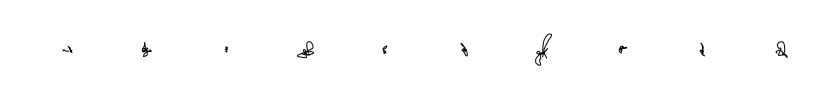

INFO:tensorflow:step: 3020, learning_rate: 0.0001, loss: 0.5714, xy_loss: 0.0460, pen_loss: 0.5254, time_taken: 4.78
INFO:tensorflow:step: 3040, learning_rate: 0.0001, loss: 0.5583, xy_loss: 0.0324, pen_loss: 0.5259, time_taken: 1.50
INFO:tensorflow:step: 3060, learning_rate: 0.0001, loss: 0.5497, xy_loss: 0.0283, pen_loss: 0.5213, time_taken: 1.53
INFO:tensorflow:step: 3080, learning_rate: 0.0001, loss: 0.5583, xy_loss: 0.0357, pen_loss: 0.5225, time_taken: 1.53
INFO:tensorflow:step: 3100, learning_rate: 0.0001, loss: 0.5430, xy_loss: 0.0224, pen_loss: 0.5207, time_taken: 1.51
INFO:tensorflow:step: 3120, learning_rate: 0.0001, loss: 0.5423, xy_loss: 0.0234, pen_loss: 0.5189, time_taken: 1.53
INFO:tensorflow:step: 3140, learning_rate: 0.0001, loss: 0.5560, xy_loss: 0.0380, pen_loss: 0.5180, time_taken: 1.64
INFO:tensorflow:step: 3160, learning_rate: 0.0001, loss: 0.5269, xy_loss: 0.0131, pen_loss: 0.5138, time_taken: 1.51
INFO:tensorflow:step: 3180, learning_rate: 0.0001, loss: 0.5425,

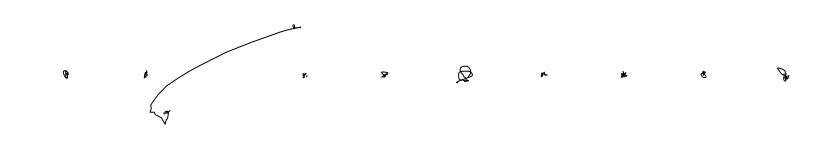

INFO:tensorflow:validation, step: 4000, loss: 0.4557, xy_loss: -0.0286, pen_loss: 0.4843, time_taken: 0.80
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 4000, loss: 0.4519, xy_loss: -0.0310, pen_loss: 0.4829, time_taken: 0.86
INFO:tensorflow:step: 4020, learning_rate: 0.0001, loss: 0.4538, xy_loss: -0.0297, pen_loss: 0.4835, time_taken: 2.40
INFO:tensorflow:step: 4040, learning_rate: 0.0001, loss: 0.4404, xy_loss: -0.0431, pen_loss: 0.4835, time_taken: 1.53
INFO:tensorflow:step: 4060, learning_rate: 0.0001, loss: 0.4460, xy_loss: -0.0363, pen_loss: 0.4823, time_taken: 1.52
INFO:tensorflow:step: 4080, learning_rate: 0.0001, loss: 0.4435, xy_loss: -0.0368, pen_loss: 0.4803, time_taken: 1.53
INFO:tensorflow:step: 4100, learning_rate: 0.0001, loss: 0.4458, xy_loss: -0.0380, pen_loss: 0.4838, time_taken: 1.51
INFO:tensorflow:step: 4120, learning_rate: 0.0001, loss: 0.4443, xy_loss: -0.0357, pen_loss: 0.4800, time_taken: 1.53
INFO:tenso

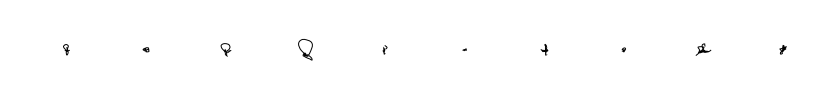

INFO:tensorflow:step: 5020, learning_rate: 0.0001, loss: 0.3554, xy_loss: -0.0926, pen_loss: 0.4479, time_taken: 4.78
INFO:tensorflow:step: 5040, learning_rate: 0.0001, loss: 0.3643, xy_loss: -0.0848, pen_loss: 0.4491, time_taken: 1.50
INFO:tensorflow:step: 5060, learning_rate: 0.0001, loss: 0.3514, xy_loss: -0.0969, pen_loss: 0.4483, time_taken: 1.55
INFO:tensorflow:step: 5080, learning_rate: 0.0001, loss: 0.3583, xy_loss: -0.0885, pen_loss: 0.4468, time_taken: 1.52
INFO:tensorflow:step: 5100, learning_rate: 0.0001, loss: 0.3572, xy_loss: -0.0901, pen_loss: 0.4473, time_taken: 1.54
INFO:tensorflow:step: 5120, learning_rate: 0.0001, loss: 0.3344, xy_loss: -0.1111, pen_loss: 0.4455, time_taken: 1.52
INFO:tensorflow:step: 5140, learning_rate: 0.0001, loss: 0.3384, xy_loss: -0.1080, pen_loss: 0.4463, time_taken: 1.50
INFO:tensorflow:step: 5160, learning_rate: 0.0001, loss: 0.3490, xy_loss: -0.0948, pen_loss: 0.4439, time_taken: 1.52
INFO:tensorflow:step: 5180, learning_rate: 0.0001, loss:

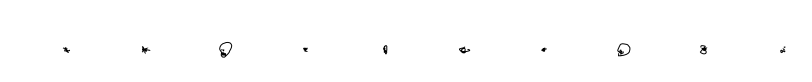

INFO:tensorflow:validation, step: 6000, loss: 0.2817, xy_loss: -0.1399, pen_loss: 0.4217, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 6000, loss: 0.2785, xy_loss: -0.1421, pen_loss: 0.4205, time_taken: 0.85
INFO:tensorflow:step: 6020, learning_rate: 0.0001, loss: 0.2738, xy_loss: -0.1458, pen_loss: 0.4196, time_taken: 2.36
INFO:tensorflow:step: 6040, learning_rate: 0.0001, loss: 0.2945, xy_loss: -0.1287, pen_loss: 0.4232, time_taken: 1.54
INFO:tensorflow:step: 6060, learning_rate: 0.0001, loss: 0.2831, xy_loss: -0.1383, pen_loss: 0.4214, time_taken: 1.53
INFO:tensorflow:step: 6080, learning_rate: 0.0001, loss: 0.2727, xy_loss: -0.1467, pen_loss: 0.4194, time_taken: 1.51
INFO:tensorflow:step: 6100, learning_rate: 0.0001, loss: 0.2527, xy_loss: -0.1641, pen_loss: 0.4169, time_taken: 1.53
INFO:tensorflow:step: 6120, learning_rate: 0.0001, loss: 0.2686, xy_loss: -0.1497, pen_loss: 0.4184, time_taken: 1.48
INFO:tenso

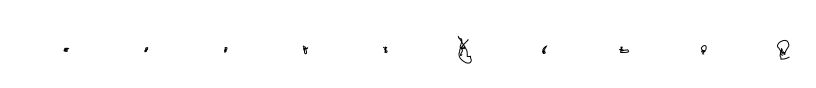

INFO:tensorflow:step: 7020, learning_rate: 0.0001, loss: 0.2012, xy_loss: -0.1947, pen_loss: 0.3959, time_taken: 4.04
INFO:tensorflow:step: 7040, learning_rate: 0.0001, loss: 0.2131, xy_loss: -0.1858, pen_loss: 0.3989, time_taken: 1.50
INFO:tensorflow:step: 7060, learning_rate: 0.0001, loss: 0.1959, xy_loss: -0.1978, pen_loss: 0.3937, time_taken: 1.49
INFO:tensorflow:step: 7080, learning_rate: 0.0001, loss: 0.2044, xy_loss: -0.1908, pen_loss: 0.3952, time_taken: 1.50
INFO:tensorflow:step: 7100, learning_rate: 0.0001, loss: 0.1985, xy_loss: -0.1961, pen_loss: 0.3946, time_taken: 1.52
INFO:tensorflow:step: 7120, learning_rate: 0.0001, loss: 0.2147, xy_loss: -0.1797, pen_loss: 0.3944, time_taken: 1.51
INFO:tensorflow:step: 7140, learning_rate: 0.0001, loss: 0.1971, xy_loss: -0.1950, pen_loss: 0.3922, time_taken: 1.51
INFO:tensorflow:step: 7160, learning_rate: 0.0001, loss: 0.1929, xy_loss: -0.2000, pen_loss: 0.3929, time_taken: 1.49
INFO:tensorflow:step: 7180, learning_rate: 0.0001, loss:

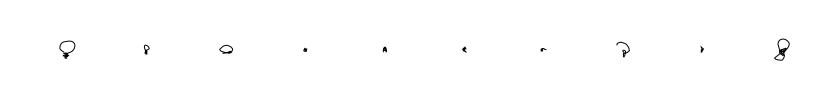

INFO:tensorflow:validation, step: 8000, loss: 0.1494, xy_loss: -0.2267, pen_loss: 0.3761, time_taken: 0.74
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 8000, loss: 0.1452, xy_loss: -0.2300, pen_loss: 0.3752, time_taken: 0.86
INFO:tensorflow:step: 8020, learning_rate: 0.0001, loss: 0.1426, xy_loss: -0.2328, pen_loss: 0.3754, time_taken: 2.37
INFO:tensorflow:step: 8040, learning_rate: 0.0001, loss: 0.1451, xy_loss: -0.2308, pen_loss: 0.3759, time_taken: 1.50
INFO:tensorflow:step: 8060, learning_rate: 0.0001, loss: 0.1415, xy_loss: -0.2325, pen_loss: 0.3741, time_taken: 1.50
INFO:tensorflow:step: 8080, learning_rate: 0.0001, loss: 0.1252, xy_loss: -0.2482, pen_loss: 0.3734, time_taken: 1.51
INFO:tensorflow:step: 8100, learning_rate: 0.0001, loss: 0.1517, xy_loss: -0.2227, pen_loss: 0.3744, time_taken: 1.50
INFO:tensorflow:step: 8120, learning_rate: 0.0000, loss: 0.1421, xy_loss: -0.2320, pen_loss: 0.3741, time_taken: 1.51
INFO:tenso

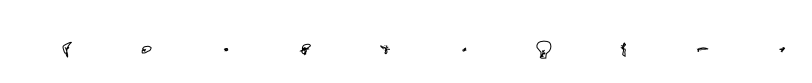

INFO:tensorflow:step: 9020, learning_rate: 0.0000, loss: 0.0789, xy_loss: -0.2788, pen_loss: 0.3577, time_taken: 4.61
INFO:tensorflow:step: 9040, learning_rate: 0.0000, loss: 0.1065, xy_loss: -0.2510, pen_loss: 0.3575, time_taken: 1.53
INFO:tensorflow:step: 9060, learning_rate: 0.0000, loss: 0.0737, xy_loss: -0.2830, pen_loss: 0.3567, time_taken: 1.52
INFO:tensorflow:step: 9080, learning_rate: 0.0000, loss: 0.0869, xy_loss: -0.2680, pen_loss: 0.3549, time_taken: 1.53
INFO:tensorflow:step: 9100, learning_rate: 0.0000, loss: 0.0928, xy_loss: -0.2632, pen_loss: 0.3561, time_taken: 1.52
INFO:tensorflow:step: 9120, learning_rate: 0.0000, loss: 0.0777, xy_loss: -0.2785, pen_loss: 0.3562, time_taken: 1.52
INFO:tensorflow:step: 9140, learning_rate: 0.0000, loss: 0.0654, xy_loss: -0.2894, pen_loss: 0.3549, time_taken: 1.54
INFO:tensorflow:step: 9160, learning_rate: 0.0000, loss: 0.0872, xy_loss: -0.2671, pen_loss: 0.3543, time_taken: 1.52
INFO:tensorflow:step: 9180, learning_rate: 0.0000, loss:

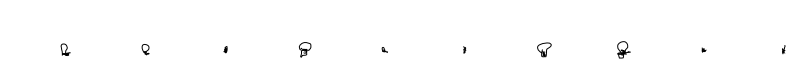

INFO:tensorflow:validation, step: 10000, loss: 0.0402, xy_loss: -0.3015, pen_loss: 0.3417, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 10000, loss: 0.0377, xy_loss: -0.3032, pen_loss: 0.3409, time_taken: 1.09
INFO:tensorflow:step: 10020, learning_rate: 0.0000, loss: 0.0533, xy_loss: -0.2891, pen_loss: 0.3423, time_taken: 2.59
INFO:tensorflow:step: 10040, learning_rate: 0.0000, loss: 0.0384, xy_loss: -0.3038, pen_loss: 0.3422, time_taken: 1.53
INFO:tensorflow:step: 10060, learning_rate: 0.0000, loss: 0.0361, xy_loss: -0.3042, pen_loss: 0.3403, time_taken: 1.53
INFO:tensorflow:step: 10080, learning_rate: 0.0000, loss: 0.0324, xy_loss: -0.3082, pen_loss: 0.3406, time_taken: 1.53
INFO:tensorflow:step: 10100, learning_rate: 0.0000, loss: 0.0449, xy_loss: -0.2951, pen_loss: 0.3399, time_taken: 1.50
INFO:tensorflow:step: 10120, learning_rate: 0.0000, loss: 0.0240, xy_loss: -0.3161, pen_loss: 0.3401, time_taken: 1.52
IN

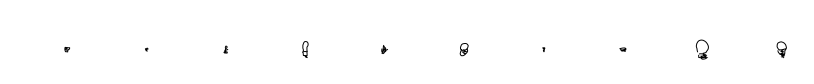

INFO:tensorflow:step: 11020, learning_rate: 0.0000, loss: -0.0059, xy_loss: -0.3327, pen_loss: 0.3268, time_taken: 4.27
INFO:tensorflow:step: 11040, learning_rate: 0.0000, loss: -0.0002, xy_loss: -0.3291, pen_loss: 0.3289, time_taken: 1.52
INFO:tensorflow:step: 11060, learning_rate: 0.0000, loss: -0.0406, xy_loss: -0.3670, pen_loss: 0.3264, time_taken: 1.54
INFO:tensorflow:step: 11080, learning_rate: 0.0000, loss: -0.0271, xy_loss: -0.3527, pen_loss: 0.3256, time_taken: 1.52
INFO:tensorflow:step: 11100, learning_rate: 0.0000, loss: -0.0137, xy_loss: -0.3395, pen_loss: 0.3259, time_taken: 1.53
INFO:tensorflow:step: 11120, learning_rate: 0.0000, loss: 0.0021, xy_loss: -0.3251, pen_loss: 0.3271, time_taken: 1.51
INFO:tensorflow:step: 11140, learning_rate: 0.0000, loss: -0.0292, xy_loss: -0.3546, pen_loss: 0.3254, time_taken: 1.53
INFO:tensorflow:step: 11160, learning_rate: 0.0000, loss: -0.0214, xy_loss: -0.3469, pen_loss: 0.3255, time_taken: 1.54
INFO:tensorflow:step: 11180, learning_rat

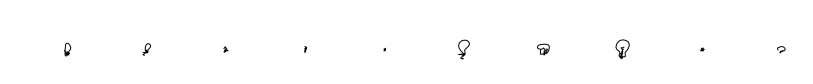

INFO:tensorflow:validation, step: 12000, loss: -0.0517, xy_loss: -0.3668, pen_loss: 0.3150, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 12000, loss: -0.0560, xy_loss: -0.3703, pen_loss: 0.3143, time_taken: 0.86
INFO:tensorflow:step: 12020, learning_rate: 0.0000, loss: -0.0618, xy_loss: -0.3759, pen_loss: 0.3142, time_taken: 2.37
INFO:tensorflow:step: 12040, learning_rate: 0.0000, loss: -0.0560, xy_loss: -0.3694, pen_loss: 0.3134, time_taken: 1.56
INFO:tensorflow:step: 12060, learning_rate: 0.0000, loss: -0.0544, xy_loss: -0.3682, pen_loss: 0.3139, time_taken: 1.52
INFO:tensorflow:step: 12080, learning_rate: 0.0000, loss: -0.0607, xy_loss: -0.3765, pen_loss: 0.3158, time_taken: 1.51
INFO:tensorflow:step: 12100, learning_rate: 0.0000, loss: -0.0458, xy_loss: -0.3602, pen_loss: 0.3144, time_taken: 1.54
INFO:tensorflow:step: 12120, learning_rate: 0.0000, loss: -0.0734, xy_loss: -0.3862, pen_loss: 0.3128, time_taken:

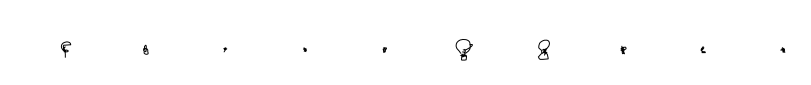

INFO:tensorflow:step: 13020, learning_rate: 0.0000, loss: -0.1052, xy_loss: -0.4072, pen_loss: 0.3020, time_taken: 4.79
INFO:tensorflow:step: 13040, learning_rate: 0.0000, loss: -0.1055, xy_loss: -0.4076, pen_loss: 0.3021, time_taken: 1.53
INFO:tensorflow:step: 13060, learning_rate: 0.0000, loss: -0.1007, xy_loss: -0.4015, pen_loss: 0.3008, time_taken: 1.49
INFO:tensorflow:step: 13080, learning_rate: 0.0000, loss: -0.1184, xy_loss: -0.4217, pen_loss: 0.3033, time_taken: 1.52
INFO:tensorflow:step: 13100, learning_rate: 0.0000, loss: -0.1104, xy_loss: -0.4111, pen_loss: 0.3006, time_taken: 1.54
INFO:tensorflow:step: 13120, learning_rate: 0.0000, loss: -0.1028, xy_loss: -0.4040, pen_loss: 0.3012, time_taken: 1.51
INFO:tensorflow:step: 13140, learning_rate: 0.0000, loss: -0.1078, xy_loss: -0.4102, pen_loss: 0.3025, time_taken: 1.52
INFO:tensorflow:step: 13160, learning_rate: 0.0000, loss: -0.1017, xy_loss: -0.4029, pen_loss: 0.3012, time_taken: 1.53
INFO:tensorflow:step: 13180, learning_ra

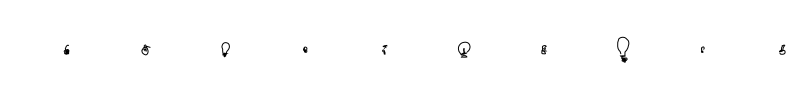

INFO:tensorflow:validation, step: 14000, loss: -0.1271, xy_loss: -0.4211, pen_loss: 0.2940, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 14000, loss: -0.1306, xy_loss: -0.4240, pen_loss: 0.2934, time_taken: 0.85
INFO:tensorflow:step: 14020, learning_rate: 0.0000, loss: -0.1184, xy_loss: -0.4086, pen_loss: 0.2902, time_taken: 2.39
INFO:tensorflow:step: 14040, learning_rate: 0.0000, loss: -0.1403, xy_loss: -0.4336, pen_loss: 0.2933, time_taken: 1.52
INFO:tensorflow:step: 14060, learning_rate: 0.0000, loss: -0.1280, xy_loss: -0.4213, pen_loss: 0.2933, time_taken: 1.52
INFO:tensorflow:step: 14080, learning_rate: 0.0000, loss: -0.1198, xy_loss: -0.4125, pen_loss: 0.2927, time_taken: 1.50
INFO:tensorflow:step: 14100, learning_rate: 0.0000, loss: -0.1415, xy_loss: -0.4343, pen_loss: 0.2927, time_taken: 1.55
INFO:tensorflow:step: 14120, learning_rate: 0.0000, loss: -0.1334, xy_loss: -0.4251, pen_loss: 0.2917, time_taken:

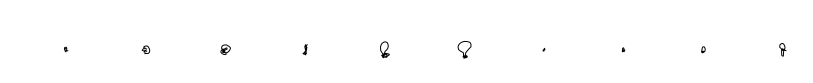

INFO:tensorflow:step: 15020, learning_rate: 0.0000, loss: -0.1724, xy_loss: -0.4578, pen_loss: 0.2854, time_taken: 4.78
INFO:tensorflow:step: 15040, learning_rate: 0.0000, loss: -0.1670, xy_loss: -0.4513, pen_loss: 0.2843, time_taken: 1.50
INFO:tensorflow:step: 15060, learning_rate: 0.0000, loss: -0.1742, xy_loss: -0.4585, pen_loss: 0.2843, time_taken: 1.51
INFO:tensorflow:step: 15080, learning_rate: 0.0000, loss: -0.1537, xy_loss: -0.4385, pen_loss: 0.2848, time_taken: 1.53
INFO:tensorflow:step: 15100, learning_rate: 0.0000, loss: -0.1652, xy_loss: -0.4498, pen_loss: 0.2846, time_taken: 1.52
INFO:tensorflow:step: 15120, learning_rate: 0.0000, loss: -0.1568, xy_loss: -0.4391, pen_loss: 0.2823, time_taken: 1.51
INFO:tensorflow:step: 15140, learning_rate: 0.0000, loss: -0.1729, xy_loss: -0.4583, pen_loss: 0.2853, time_taken: 1.53
INFO:tensorflow:step: 15160, learning_rate: 0.0000, loss: -0.1765, xy_loss: -0.4596, pen_loss: 0.2830, time_taken: 1.53
INFO:tensorflow:step: 15180, learning_ra

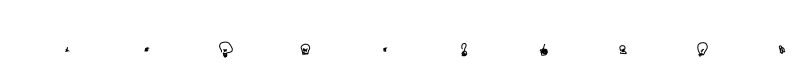

INFO:tensorflow:validation, step: 16000, loss: -0.1927, xy_loss: -0.4699, pen_loss: 0.2772, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 16000, loss: -0.1957, xy_loss: -0.4723, pen_loss: 0.2765, time_taken: 0.87
INFO:tensorflow:step: 16020, learning_rate: 0.0000, loss: -0.2041, xy_loss: -0.4810, pen_loss: 0.2769, time_taken: 2.39
INFO:tensorflow:step: 16040, learning_rate: 0.0000, loss: -0.2094, xy_loss: -0.4862, pen_loss: 0.2767, time_taken: 1.50
INFO:tensorflow:step: 16060, learning_rate: 0.0000, loss: -0.2149, xy_loss: -0.4936, pen_loss: 0.2787, time_taken: 1.51
INFO:tensorflow:step: 16080, learning_rate: 0.0000, loss: -0.1961, xy_loss: -0.4717, pen_loss: 0.2756, time_taken: 1.51
INFO:tensorflow:step: 16100, learning_rate: 0.0000, loss: -0.2058, xy_loss: -0.4810, pen_loss: 0.2752, time_taken: 1.50
INFO:tensorflow:step: 16120, learning_rate: 0.0000, loss: -0.2015, xy_loss: -0.4757, pen_loss: 0.2741, time_taken:

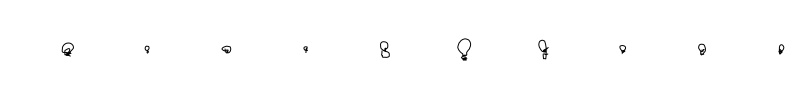

INFO:tensorflow:step: 17020, learning_rate: 0.0000, loss: -0.2121, xy_loss: -0.4814, pen_loss: 0.2692, time_taken: 4.09
INFO:tensorflow:step: 17040, learning_rate: 0.0000, loss: -0.2421, xy_loss: -0.5113, pen_loss: 0.2692, time_taken: 1.52
INFO:tensorflow:step: 17060, learning_rate: 0.0000, loss: -0.2203, xy_loss: -0.4893, pen_loss: 0.2690, time_taken: 1.50
INFO:tensorflow:step: 17080, learning_rate: 0.0000, loss: -0.2418, xy_loss: -0.5107, pen_loss: 0.2690, time_taken: 1.52
INFO:tensorflow:step: 17100, learning_rate: 0.0000, loss: -0.2335, xy_loss: -0.5024, pen_loss: 0.2688, time_taken: 1.52
INFO:tensorflow:step: 17120, learning_rate: 0.0000, loss: -0.2343, xy_loss: -0.5026, pen_loss: 0.2682, time_taken: 1.54
INFO:tensorflow:step: 17140, learning_rate: 0.0000, loss: -0.2412, xy_loss: -0.5106, pen_loss: 0.2694, time_taken: 1.55
INFO:tensorflow:step: 17160, learning_rate: 0.0000, loss: -0.2259, xy_loss: -0.4941, pen_loss: 0.2682, time_taken: 1.50
INFO:tensorflow:step: 17180, learning_ra

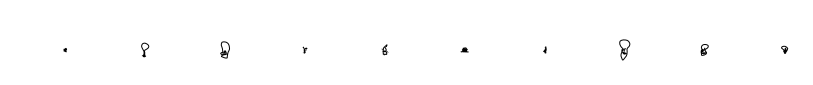

INFO:tensorflow:validation, step: 18000, loss: -0.2494, xy_loss: -0.5127, pen_loss: 0.2633, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 18000, loss: -0.2532, xy_loss: -0.5160, pen_loss: 0.2627, time_taken: 0.85
INFO:tensorflow:step: 18020, learning_rate: 0.0000, loss: -0.2670, xy_loss: -0.5309, pen_loss: 0.2639, time_taken: 2.36
INFO:tensorflow:step: 18040, learning_rate: 0.0000, loss: -0.2472, xy_loss: -0.5102, pen_loss: 0.2630, time_taken: 1.51
INFO:tensorflow:step: 18060, learning_rate: 0.0000, loss: -0.2478, xy_loss: -0.5087, pen_loss: 0.2609, time_taken: 1.50
INFO:tensorflow:step: 18080, learning_rate: 0.0000, loss: -0.2559, xy_loss: -0.5157, pen_loss: 0.2598, time_taken: 1.50
INFO:tensorflow:step: 18100, learning_rate: 0.0000, loss: -0.2519, xy_loss: -0.5128, pen_loss: 0.2610, time_taken: 1.51
INFO:tensorflow:step: 18120, learning_rate: 0.0000, loss: -0.2543, xy_loss: -0.5156, pen_loss: 0.2613, time_taken:

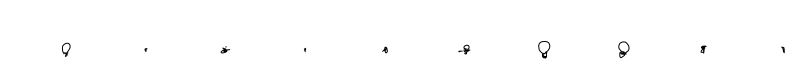

INFO:tensorflow:step: 19020, learning_rate: 0.0000, loss: -0.2883, xy_loss: -0.5453, pen_loss: 0.2570, time_taken: 4.53
INFO:tensorflow:step: 19040, learning_rate: 0.0000, loss: -0.2793, xy_loss: -0.5341, pen_loss: 0.2549, time_taken: 1.54
INFO:tensorflow:step: 19060, learning_rate: 0.0000, loss: -0.3021, xy_loss: -0.5586, pen_loss: 0.2566, time_taken: 1.54
INFO:tensorflow:step: 19080, learning_rate: 0.0000, loss: -0.2725, xy_loss: -0.5296, pen_loss: 0.2571, time_taken: 1.51
INFO:tensorflow:step: 19100, learning_rate: 0.0000, loss: -0.2807, xy_loss: -0.5389, pen_loss: 0.2583, time_taken: 1.50
INFO:tensorflow:step: 19120, learning_rate: 0.0000, loss: -0.2742, xy_loss: -0.5297, pen_loss: 0.2555, time_taken: 1.51
INFO:tensorflow:step: 19140, learning_rate: 0.0000, loss: -0.2842, xy_loss: -0.5404, pen_loss: 0.2562, time_taken: 1.51
INFO:tensorflow:step: 19160, learning_rate: 0.0000, loss: -0.2901, xy_loss: -0.5463, pen_loss: 0.2562, time_taken: 1.56
INFO:tensorflow:step: 19180, learning_ra

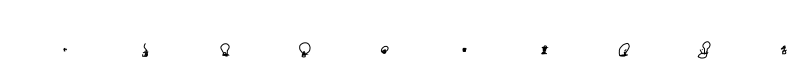

INFO:tensorflow:validation, step: 20000, loss: -0.2967, xy_loss: -0.5488, pen_loss: 0.2520, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 20000, loss: -0.3000, xy_loss: -0.5516, pen_loss: 0.2516, time_taken: 0.85
INFO:tensorflow:step: 20020, learning_rate: 0.0000, loss: -0.3236, xy_loss: -0.5763, pen_loss: 0.2527, time_taken: 2.35
INFO:tensorflow:step: 20040, learning_rate: 0.0000, loss: -0.2964, xy_loss: -0.5473, pen_loss: 0.2509, time_taken: 1.52
INFO:tensorflow:step: 20060, learning_rate: 0.0000, loss: -0.3104, xy_loss: -0.5617, pen_loss: 0.2513, time_taken: 1.52
INFO:tensorflow:step: 20080, learning_rate: 0.0000, loss: -0.3008, xy_loss: -0.5498, pen_loss: 0.2490, time_taken: 1.51
INFO:tensorflow:step: 20100, learning_rate: 0.0000, loss: -0.3280, xy_loss: -0.5787, pen_loss: 0.2507, time_taken: 1.54
INFO:tensorflow:step: 20120, learning_rate: 0.0000, loss: -0.3035, xy_loss: -0.5513, pen_loss: 0.2478, time_taken:

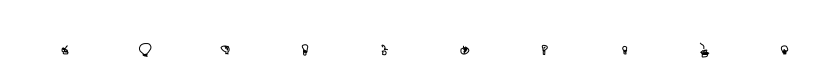

INFO:tensorflow:step: 21020, learning_rate: 0.0000, loss: -0.3272, xy_loss: -0.5721, pen_loss: 0.2449, time_taken: 4.60
INFO:tensorflow:step: 21040, learning_rate: 0.0000, loss: -0.3225, xy_loss: -0.5691, pen_loss: 0.2466, time_taken: 1.52
INFO:tensorflow:step: 21060, learning_rate: 0.0000, loss: -0.3265, xy_loss: -0.5718, pen_loss: 0.2453, time_taken: 1.50
INFO:tensorflow:step: 21080, learning_rate: 0.0000, loss: -0.3291, xy_loss: -0.5750, pen_loss: 0.2458, time_taken: 1.52
INFO:tensorflow:step: 21100, learning_rate: 0.0000, loss: -0.3469, xy_loss: -0.5929, pen_loss: 0.2460, time_taken: 1.53
INFO:tensorflow:step: 21120, learning_rate: 0.0000, loss: -0.3239, xy_loss: -0.5695, pen_loss: 0.2456, time_taken: 1.50
INFO:tensorflow:step: 21140, learning_rate: 0.0000, loss: -0.3326, xy_loss: -0.5802, pen_loss: 0.2476, time_taken: 1.52
INFO:tensorflow:step: 21160, learning_rate: 0.0000, loss: -0.3337, xy_loss: -0.5789, pen_loss: 0.2451, time_taken: 1.55
INFO:tensorflow:step: 21180, learning_ra

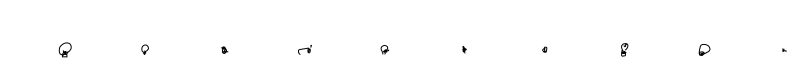

INFO:tensorflow:validation, step: 22000, loss: -0.3415, xy_loss: -0.5838, pen_loss: 0.2423, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 22000, loss: -0.3445, xy_loss: -0.5864, pen_loss: 0.2419, time_taken: 0.86
INFO:tensorflow:step: 22020, learning_rate: 0.0000, loss: -0.3395, xy_loss: -0.5826, pen_loss: 0.2431, time_taken: 2.40
INFO:tensorflow:step: 22040, learning_rate: 0.0000, loss: -0.3408, xy_loss: -0.5811, pen_loss: 0.2403, time_taken: 1.52
INFO:tensorflow:step: 22060, learning_rate: 0.0000, loss: -0.3519, xy_loss: -0.5923, pen_loss: 0.2404, time_taken: 1.56
INFO:tensorflow:step: 22080, learning_rate: 0.0000, loss: -0.3544, xy_loss: -0.5956, pen_loss: 0.2412, time_taken: 1.50
INFO:tensorflow:step: 22100, learning_rate: 0.0000, loss: -0.3500, xy_loss: -0.5906, pen_loss: 0.2406, time_taken: 1.50
INFO:tensorflow:step: 22120, learning_rate: 0.0000, loss: -0.3384, xy_loss: -0.5803, pen_loss: 0.2419, time_taken:

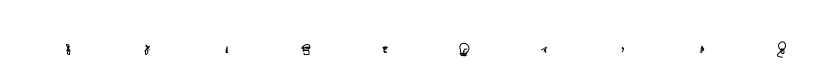

INFO:tensorflow:step: 23020, learning_rate: 0.0000, loss: -0.3700, xy_loss: -0.6066, pen_loss: 0.2366, time_taken: 4.47
INFO:tensorflow:step: 23040, learning_rate: 0.0000, loss: -0.3686, xy_loss: -0.6043, pen_loss: 0.2357, time_taken: 1.49
INFO:tensorflow:step: 23060, learning_rate: 0.0000, loss: -0.3851, xy_loss: -0.6219, pen_loss: 0.2368, time_taken: 1.52
INFO:tensorflow:step: 23080, learning_rate: 0.0000, loss: -0.3726, xy_loss: -0.6113, pen_loss: 0.2387, time_taken: 1.53
INFO:tensorflow:step: 23100, learning_rate: 0.0000, loss: -0.3585, xy_loss: -0.5945, pen_loss: 0.2361, time_taken: 1.50
INFO:tensorflow:step: 23120, learning_rate: 0.0000, loss: -0.3691, xy_loss: -0.6052, pen_loss: 0.2361, time_taken: 1.53
INFO:tensorflow:step: 23140, learning_rate: 0.0000, loss: -0.3666, xy_loss: -0.6042, pen_loss: 0.2376, time_taken: 1.54
INFO:tensorflow:step: 23160, learning_rate: 0.0000, loss: -0.3713, xy_loss: -0.6062, pen_loss: 0.2349, time_taken: 1.53
INFO:tensorflow:step: 23180, learning_ra

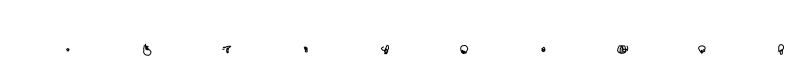

INFO:tensorflow:validation, step: 24000, loss: -0.3803, xy_loss: -0.6143, pen_loss: 0.2340, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 24000, loss: -0.3835, xy_loss: -0.6171, pen_loss: 0.2335, time_taken: 0.86
INFO:tensorflow:step: 24020, learning_rate: 0.0000, loss: -0.3867, xy_loss: -0.6230, pen_loss: 0.2363, time_taken: 2.48
INFO:tensorflow:step: 24040, learning_rate: 0.0000, loss: -0.3692, xy_loss: -0.6013, pen_loss: 0.2321, time_taken: 1.50
INFO:tensorflow:step: 24060, learning_rate: 0.0000, loss: -0.3889, xy_loss: -0.6222, pen_loss: 0.2333, time_taken: 1.54
INFO:tensorflow:step: 24080, learning_rate: 0.0000, loss: -0.4109, xy_loss: -0.6430, pen_loss: 0.2322, time_taken: 1.53
INFO:tensorflow:step: 24100, learning_rate: 0.0000, loss: -0.4012, xy_loss: -0.6336, pen_loss: 0.2323, time_taken: 1.54
INFO:tensorflow:step: 24120, learning_rate: 0.0000, loss: -0.3889, xy_loss: -0.6206, pen_loss: 0.2317, time_taken:

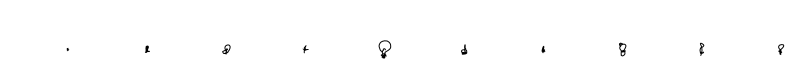

INFO:tensorflow:step: 25020, learning_rate: 0.0000, loss: -0.3955, xy_loss: -0.6249, pen_loss: 0.2294, time_taken: 4.71
INFO:tensorflow:step: 25040, learning_rate: 0.0000, loss: -0.4057, xy_loss: -0.6355, pen_loss: 0.2298, time_taken: 1.51
INFO:tensorflow:step: 25060, learning_rate: 0.0000, loss: -0.3998, xy_loss: -0.6307, pen_loss: 0.2309, time_taken: 1.62
INFO:tensorflow:step: 25080, learning_rate: 0.0000, loss: -0.4123, xy_loss: -0.6404, pen_loss: 0.2281, time_taken: 1.50
INFO:tensorflow:step: 25100, learning_rate: 0.0000, loss: -0.4106, xy_loss: -0.6394, pen_loss: 0.2288, time_taken: 1.52
INFO:tensorflow:step: 25120, learning_rate: 0.0000, loss: -0.3909, xy_loss: -0.6190, pen_loss: 0.2281, time_taken: 1.51
INFO:tensorflow:step: 25140, learning_rate: 0.0000, loss: -0.4004, xy_loss: -0.6311, pen_loss: 0.2307, time_taken: 1.53
INFO:tensorflow:step: 25160, learning_rate: 0.0000, loss: -0.3974, xy_loss: -0.6249, pen_loss: 0.2274, time_taken: 1.51
INFO:tensorflow:step: 25180, learning_ra

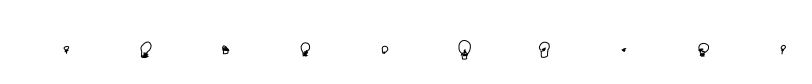

INFO:tensorflow:validation, step: 26000, loss: -0.4148, xy_loss: -0.6417, pen_loss: 0.2269, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 26000, loss: -0.4177, xy_loss: -0.6442, pen_loss: 0.2265, time_taken: 0.87
INFO:tensorflow:step: 26020, learning_rate: 0.0000, loss: -0.4173, xy_loss: -0.6436, pen_loss: 0.2263, time_taken: 2.40
INFO:tensorflow:step: 26040, learning_rate: 0.0000, loss: -0.4322, xy_loss: -0.6580, pen_loss: 0.2258, time_taken: 1.51
INFO:tensorflow:step: 26060, learning_rate: 0.0000, loss: -0.4205, xy_loss: -0.6469, pen_loss: 0.2264, time_taken: 1.50
INFO:tensorflow:step: 26080, learning_rate: 0.0000, loss: -0.4077, xy_loss: -0.6315, pen_loss: 0.2238, time_taken: 1.52
INFO:tensorflow:step: 26100, learning_rate: 0.0000, loss: -0.4348, xy_loss: -0.6554, pen_loss: 0.2206, time_taken: 1.66
INFO:tensorflow:step: 26120, learning_rate: 0.0000, loss: -0.4046, xy_loss: -0.6298, pen_loss: 0.2252, time_taken:

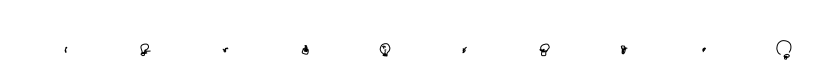

INFO:tensorflow:step: 27020, learning_rate: 0.0000, loss: -0.4277, xy_loss: -0.6493, pen_loss: 0.2215, time_taken: 4.61
INFO:tensorflow:step: 27040, learning_rate: 0.0000, loss: -0.4490, xy_loss: -0.6709, pen_loss: 0.2219, time_taken: 1.52
INFO:tensorflow:step: 27060, learning_rate: 0.0000, loss: -0.4407, xy_loss: -0.6621, pen_loss: 0.2214, time_taken: 1.51
INFO:tensorflow:step: 27080, learning_rate: 0.0000, loss: -0.4361, xy_loss: -0.6593, pen_loss: 0.2232, time_taken: 1.54
INFO:tensorflow:step: 27100, learning_rate: 0.0000, loss: -0.4327, xy_loss: -0.6557, pen_loss: 0.2230, time_taken: 1.55
INFO:tensorflow:step: 27120, learning_rate: 0.0000, loss: -0.4432, xy_loss: -0.6662, pen_loss: 0.2230, time_taken: 1.53
INFO:tensorflow:step: 27140, learning_rate: 0.0000, loss: -0.4405, xy_loss: -0.6639, pen_loss: 0.2234, time_taken: 1.51
INFO:tensorflow:step: 27160, learning_rate: 0.0000, loss: -0.4420, xy_loss: -0.6671, pen_loss: 0.2251, time_taken: 1.63
INFO:tensorflow:step: 27180, learning_ra

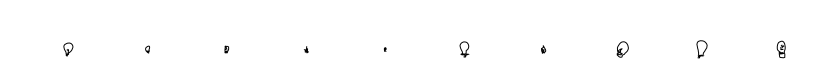

INFO:tensorflow:validation, step: 28000, loss: -0.4472, xy_loss: -0.6678, pen_loss: 0.2206, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 28000, loss: -0.4502, xy_loss: -0.6704, pen_loss: 0.2202, time_taken: 1.10
INFO:tensorflow:step: 28020, learning_rate: 0.0000, loss: -0.4468, xy_loss: -0.6672, pen_loss: 0.2204, time_taken: 2.60
INFO:tensorflow:step: 28040, learning_rate: 0.0000, loss: -0.4580, xy_loss: -0.6776, pen_loss: 0.2196, time_taken: 1.49
INFO:tensorflow:step: 28060, learning_rate: 0.0000, loss: -0.4511, xy_loss: -0.6716, pen_loss: 0.2204, time_taken: 1.52
INFO:tensorflow:step: 28080, learning_rate: 0.0000, loss: -0.4540, xy_loss: -0.6748, pen_loss: 0.2208, time_taken: 1.51
INFO:tensorflow:step: 28100, learning_rate: 0.0000, loss: -0.4579, xy_loss: -0.6759, pen_loss: 0.2181, time_taken: 1.50
INFO:tensorflow:step: 28120, learning_rate: 0.0000, loss: -0.4557, xy_loss: -0.6767, pen_loss: 0.2209, time_taken:

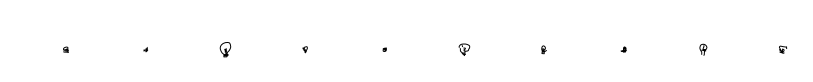

INFO:tensorflow:step: 29020, learning_rate: 0.0000, loss: -0.4660, xy_loss: -0.6811, pen_loss: 0.2151, time_taken: 4.43
INFO:tensorflow:step: 29040, learning_rate: 0.0000, loss: -0.4636, xy_loss: -0.6793, pen_loss: 0.2157, time_taken: 1.51
INFO:tensorflow:step: 29060, learning_rate: 0.0000, loss: -0.4770, xy_loss: -0.6940, pen_loss: 0.2170, time_taken: 1.55
INFO:tensorflow:step: 29080, learning_rate: 0.0000, loss: -0.4604, xy_loss: -0.6756, pen_loss: 0.2152, time_taken: 1.52
INFO:tensorflow:step: 29100, learning_rate: 0.0000, loss: -0.4742, xy_loss: -0.6931, pen_loss: 0.2189, time_taken: 1.52
INFO:tensorflow:step: 29120, learning_rate: 0.0000, loss: -0.4666, xy_loss: -0.6847, pen_loss: 0.2182, time_taken: 1.51
INFO:tensorflow:step: 29140, learning_rate: 0.0000, loss: -0.4783, xy_loss: -0.6935, pen_loss: 0.2152, time_taken: 1.52
INFO:tensorflow:step: 29160, learning_rate: 0.0000, loss: -0.4718, xy_loss: -0.6872, pen_loss: 0.2155, time_taken: 1.52
INFO:tensorflow:step: 29180, learning_ra

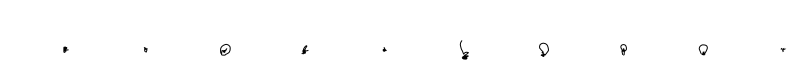

INFO:tensorflow:validation, step: 30000, loss: -0.4745, xy_loss: -0.6896, pen_loss: 0.2151, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 30000, loss: -0.4775, xy_loss: -0.6922, pen_loss: 0.2147, time_taken: 0.85
INFO:tensorflow:step: 30020, learning_rate: 0.0000, loss: -0.4639, xy_loss: -0.6797, pen_loss: 0.2158, time_taken: 2.37
INFO:tensorflow:step: 30040, learning_rate: 0.0000, loss: -0.4867, xy_loss: -0.7004, pen_loss: 0.2137, time_taken: 1.50
INFO:tensorflow:step: 30060, learning_rate: 0.0000, loss: -0.4845, xy_loss: -0.6977, pen_loss: 0.2132, time_taken: 1.51
INFO:tensorflow:step: 30080, learning_rate: 0.0000, loss: -0.4764, xy_loss: -0.6876, pen_loss: 0.2112, time_taken: 1.51
INFO:tensorflow:step: 30100, learning_rate: 0.0000, loss: -0.4804, xy_loss: -0.6962, pen_loss: 0.2157, time_taken: 1.52
INFO:tensorflow:step: 30120, learning_rate: 0.0000, loss: -0.4856, xy_loss: -0.7000, pen_loss: 0.2144, time_taken:

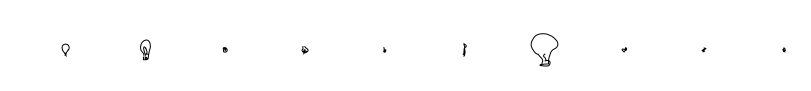

INFO:tensorflow:step: 31020, learning_rate: 0.0000, loss: -0.5064, xy_loss: -0.7192, pen_loss: 0.2129, time_taken: 4.43
INFO:tensorflow:step: 31040, learning_rate: 0.0000, loss: -0.4991, xy_loss: -0.7100, pen_loss: 0.2108, time_taken: 1.51
INFO:tensorflow:step: 31060, learning_rate: 0.0000, loss: -0.4864, xy_loss: -0.6958, pen_loss: 0.2094, time_taken: 1.49
INFO:tensorflow:step: 31080, learning_rate: 0.0000, loss: -0.5159, xy_loss: -0.7288, pen_loss: 0.2129, time_taken: 1.53
INFO:tensorflow:step: 31100, learning_rate: 0.0000, loss: -0.4934, xy_loss: -0.7048, pen_loss: 0.2115, time_taken: 1.54
INFO:tensorflow:step: 31120, learning_rate: 0.0000, loss: -0.5058, xy_loss: -0.7181, pen_loss: 0.2123, time_taken: 1.51
INFO:tensorflow:step: 31140, learning_rate: 0.0000, loss: -0.5086, xy_loss: -0.7225, pen_loss: 0.2140, time_taken: 1.52
INFO:tensorflow:step: 31160, learning_rate: 0.0000, loss: -0.5043, xy_loss: -0.7178, pen_loss: 0.2135, time_taken: 1.53
INFO:tensorflow:step: 31180, learning_ra

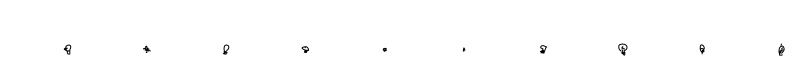

INFO:tensorflow:validation, step: 32000, loss: -0.5035, xy_loss: -0.7136, pen_loss: 0.2101, time_taken: 0.76
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 32000, loss: -0.5071, xy_loss: -0.7168, pen_loss: 0.2097, time_taken: 0.88
INFO:tensorflow:step: 32020, learning_rate: 0.0000, loss: -0.5128, xy_loss: -0.7222, pen_loss: 0.2094, time_taken: 2.38
INFO:tensorflow:step: 32040, learning_rate: 0.0000, loss: -0.5116, xy_loss: -0.7202, pen_loss: 0.2086, time_taken: 1.52
INFO:tensorflow:step: 32060, learning_rate: 0.0000, loss: -0.5084, xy_loss: -0.7170, pen_loss: 0.2086, time_taken: 1.52
INFO:tensorflow:step: 32080, learning_rate: 0.0000, loss: -0.5225, xy_loss: -0.7301, pen_loss: 0.2076, time_taken: 1.52
INFO:tensorflow:step: 32100, learning_rate: 0.0000, loss: -0.5031, xy_loss: -0.7126, pen_loss: 0.2095, time_taken: 1.54
INFO:tensorflow:step: 32120, learning_rate: 0.0000, loss: -0.4970, xy_loss: -0.7051, pen_loss: 0.2080, time_taken:

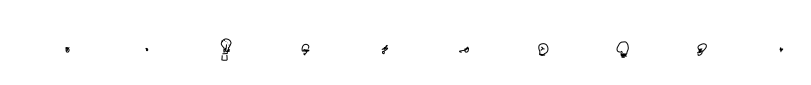

INFO:tensorflow:step: 33020, learning_rate: 0.0000, loss: -0.5171, xy_loss: -0.7241, pen_loss: 0.2071, time_taken: 4.54
INFO:tensorflow:step: 33040, learning_rate: 0.0000, loss: -0.5200, xy_loss: -0.7267, pen_loss: 0.2067, time_taken: 1.49
INFO:tensorflow:step: 33060, learning_rate: 0.0000, loss: -0.5383, xy_loss: -0.7468, pen_loss: 0.2084, time_taken: 1.54
INFO:tensorflow:step: 33080, learning_rate: 0.0000, loss: -0.5309, xy_loss: -0.7371, pen_loss: 0.2062, time_taken: 1.53
INFO:tensorflow:step: 33100, learning_rate: 0.0000, loss: -0.5155, xy_loss: -0.7205, pen_loss: 0.2049, time_taken: 1.50
INFO:tensorflow:step: 33120, learning_rate: 0.0000, loss: -0.5221, xy_loss: -0.7279, pen_loss: 0.2058, time_taken: 1.52
INFO:tensorflow:step: 33140, learning_rate: 0.0000, loss: -0.5203, xy_loss: -0.7284, pen_loss: 0.2082, time_taken: 1.52
INFO:tensorflow:step: 33160, learning_rate: 0.0000, loss: -0.5232, xy_loss: -0.7294, pen_loss: 0.2062, time_taken: 1.53
INFO:tensorflow:step: 33180, learning_ra

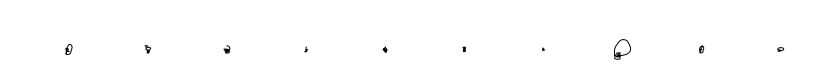

INFO:tensorflow:validation, step: 34000, loss: -0.5295, xy_loss: -0.7351, pen_loss: 0.2056, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 34000, loss: -0.5330, xy_loss: -0.7382, pen_loss: 0.2052, time_taken: 0.86
INFO:tensorflow:step: 34020, learning_rate: 0.0000, loss: -0.5385, xy_loss: -0.7433, pen_loss: 0.2048, time_taken: 2.37
INFO:tensorflow:step: 34040, learning_rate: 0.0000, loss: -0.5274, xy_loss: -0.7355, pen_loss: 0.2081, time_taken: 1.51
INFO:tensorflow:step: 34060, learning_rate: 0.0000, loss: -0.5289, xy_loss: -0.7324, pen_loss: 0.2035, time_taken: 1.52
INFO:tensorflow:step: 34080, learning_rate: 0.0000, loss: -0.5255, xy_loss: -0.7297, pen_loss: 0.2042, time_taken: 1.50
INFO:tensorflow:step: 34100, learning_rate: 0.0000, loss: -0.5423, xy_loss: -0.7470, pen_loss: 0.2047, time_taken: 1.51
INFO:tensorflow:step: 34120, learning_rate: 0.0000, loss: -0.5490, xy_loss: -0.7558, pen_loss: 0.2068, time_taken:

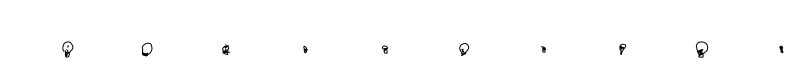

INFO:tensorflow:step: 35020, learning_rate: 0.0000, loss: -0.5386, xy_loss: -0.7400, pen_loss: 0.2014, time_taken: 4.63
INFO:tensorflow:step: 35040, learning_rate: 0.0000, loss: -0.5461, xy_loss: -0.7484, pen_loss: 0.2023, time_taken: 1.50
INFO:tensorflow:step: 35060, learning_rate: 0.0000, loss: -0.5286, xy_loss: -0.7319, pen_loss: 0.2033, time_taken: 1.50
INFO:tensorflow:step: 35080, learning_rate: 0.0000, loss: -0.5384, xy_loss: -0.7420, pen_loss: 0.2036, time_taken: 1.49
INFO:tensorflow:step: 35100, learning_rate: 0.0000, loss: -0.5417, xy_loss: -0.7438, pen_loss: 0.2021, time_taken: 1.50
INFO:tensorflow:step: 35120, learning_rate: 0.0000, loss: -0.5551, xy_loss: -0.7601, pen_loss: 0.2050, time_taken: 1.50
INFO:tensorflow:step: 35140, learning_rate: 0.0000, loss: -0.5649, xy_loss: -0.7694, pen_loss: 0.2045, time_taken: 1.51
INFO:tensorflow:step: 35160, learning_rate: 0.0000, loss: -0.5563, xy_loss: -0.7610, pen_loss: 0.2047, time_taken: 1.53
INFO:tensorflow:step: 35180, learning_ra

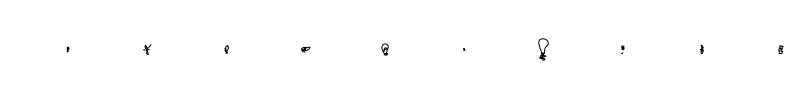

INFO:tensorflow:validation, step: 36000, loss: -0.5535, xy_loss: -0.7549, pen_loss: 0.2015, time_taken: 0.76
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 36000, loss: -0.5565, xy_loss: -0.7576, pen_loss: 0.2011, time_taken: 0.87
INFO:tensorflow:step: 36020, learning_rate: 0.0000, loss: -0.5674, xy_loss: -0.7680, pen_loss: 0.2006, time_taken: 2.37
INFO:tensorflow:step: 36040, learning_rate: 0.0000, loss: -0.5641, xy_loss: -0.7654, pen_loss: 0.2014, time_taken: 1.51
INFO:tensorflow:step: 36060, learning_rate: 0.0000, loss: -0.5519, xy_loss: -0.7518, pen_loss: 0.1999, time_taken: 1.49
INFO:tensorflow:step: 36080, learning_rate: 0.0000, loss: -0.5649, xy_loss: -0.7646, pen_loss: 0.1997, time_taken: 1.53
INFO:tensorflow:step: 36100, learning_rate: 0.0000, loss: -0.5537, xy_loss: -0.7537, pen_loss: 0.2001, time_taken: 1.51
INFO:tensorflow:step: 36120, learning_rate: 0.0000, loss: -0.5596, xy_loss: -0.7611, pen_loss: 0.2015, time_taken:

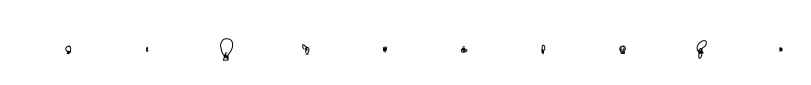

INFO:tensorflow:step: 37020, learning_rate: 0.0000, loss: -0.5623, xy_loss: -0.7603, pen_loss: 0.1980, time_taken: 4.39
INFO:tensorflow:step: 37040, learning_rate: 0.0000, loss: -0.5717, xy_loss: -0.7704, pen_loss: 0.1987, time_taken: 1.52
INFO:tensorflow:step: 37060, learning_rate: 0.0000, loss: -0.5745, xy_loss: -0.7740, pen_loss: 0.1995, time_taken: 1.50
INFO:tensorflow:step: 37080, learning_rate: 0.0000, loss: -0.5780, xy_loss: -0.7751, pen_loss: 0.1971, time_taken: 1.55
INFO:tensorflow:step: 37100, learning_rate: 0.0000, loss: -0.5868, xy_loss: -0.7844, pen_loss: 0.1976, time_taken: 1.52
INFO:tensorflow:step: 37120, learning_rate: 0.0000, loss: -0.5899, xy_loss: -0.7899, pen_loss: 0.2000, time_taken: 1.54
INFO:tensorflow:step: 37140, learning_rate: 0.0000, loss: -0.5636, xy_loss: -0.7608, pen_loss: 0.1972, time_taken: 1.50
INFO:tensorflow:step: 37160, learning_rate: 0.0000, loss: -0.5699, xy_loss: -0.7691, pen_loss: 0.1992, time_taken: 1.50
INFO:tensorflow:step: 37180, learning_ra

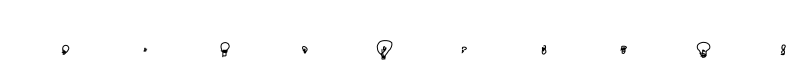

INFO:tensorflow:validation, step: 38000, loss: -0.5771, xy_loss: -0.7747, pen_loss: 0.1977, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 38000, loss: -0.5806, xy_loss: -0.7778, pen_loss: 0.1972, time_taken: 0.86
INFO:tensorflow:step: 38020, learning_rate: 0.0000, loss: -0.5824, xy_loss: -0.7799, pen_loss: 0.1975, time_taken: 2.37
INFO:tensorflow:step: 38040, learning_rate: 0.0000, loss: -0.5745, xy_loss: -0.7718, pen_loss: 0.1973, time_taken: 1.52
INFO:tensorflow:step: 38060, learning_rate: 0.0000, loss: -0.5902, xy_loss: -0.7872, pen_loss: 0.1969, time_taken: 1.55
INFO:tensorflow:step: 38080, learning_rate: 0.0000, loss: -0.5903, xy_loss: -0.7879, pen_loss: 0.1976, time_taken: 1.52
INFO:tensorflow:step: 38100, learning_rate: 0.0000, loss: -0.5757, xy_loss: -0.7710, pen_loss: 0.1954, time_taken: 1.52
INFO:tensorflow:step: 38120, learning_rate: 0.0000, loss: -0.5840, xy_loss: -0.7807, pen_loss: 0.1967, time_taken:

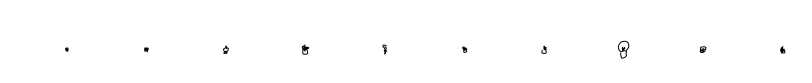

INFO:tensorflow:step: 39020, learning_rate: 0.0000, loss: -0.5869, xy_loss: -0.7785, pen_loss: 0.1916, time_taken: 4.27
INFO:tensorflow:step: 39040, learning_rate: 0.0000, loss: -0.6038, xy_loss: -0.7984, pen_loss: 0.1946, time_taken: 1.54
INFO:tensorflow:step: 39060, learning_rate: 0.0000, loss: -0.5953, xy_loss: -0.7920, pen_loss: 0.1967, time_taken: 1.51
INFO:tensorflow:step: 39080, learning_rate: 0.0000, loss: -0.6078, xy_loss: -0.8062, pen_loss: 0.1983, time_taken: 1.52
INFO:tensorflow:step: 39100, learning_rate: 0.0000, loss: -0.5924, xy_loss: -0.7865, pen_loss: 0.1941, time_taken: 1.53
INFO:tensorflow:step: 39120, learning_rate: 0.0000, loss: -0.6137, xy_loss: -0.8083, pen_loss: 0.1946, time_taken: 1.53
INFO:tensorflow:step: 39140, learning_rate: 0.0000, loss: -0.6089, xy_loss: -0.8034, pen_loss: 0.1945, time_taken: 1.53
INFO:tensorflow:step: 39160, learning_rate: 0.0000, loss: -0.5882, xy_loss: -0.7823, pen_loss: 0.1941, time_taken: 1.50
INFO:tensorflow:step: 39180, learning_ra

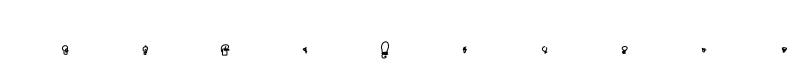

INFO:tensorflow:validation, step: 40000, loss: -0.5991, xy_loss: -0.7931, pen_loss: 0.1941, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 40000, loss: -0.6010, xy_loss: -0.7948, pen_loss: 0.1937, time_taken: 0.86
INFO:tensorflow:step: 40020, learning_rate: 0.0000, loss: -0.6061, xy_loss: -0.7998, pen_loss: 0.1937, time_taken: 2.38
INFO:tensorflow:step: 40040, learning_rate: 0.0000, loss: -0.5922, xy_loss: -0.7850, pen_loss: 0.1928, time_taken: 1.51
INFO:tensorflow:step: 40060, learning_rate: 0.0000, loss: -0.6230, xy_loss: -0.8187, pen_loss: 0.1957, time_taken: 1.53
INFO:tensorflow:step: 40080, learning_rate: 0.0000, loss: -0.5952, xy_loss: -0.7875, pen_loss: 0.1924, time_taken: 1.51
INFO:tensorflow:step: 40100, learning_rate: 0.0000, loss: -0.5925, xy_loss: -0.7842, pen_loss: 0.1917, time_taken: 1.52
INFO:tensorflow:step: 40120, learning_rate: 0.0000, loss: -0.6064, xy_loss: -0.7990, pen_loss: 0.1926, time_taken:

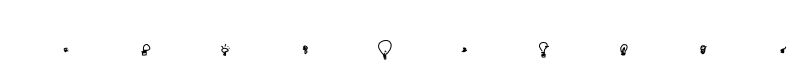

INFO:tensorflow:step: 41020, learning_rate: 0.0000, loss: -0.6272, xy_loss: -0.8207, pen_loss: 0.1935, time_taken: 4.61
INFO:tensorflow:step: 41040, learning_rate: 0.0000, loss: -0.6159, xy_loss: -0.8066, pen_loss: 0.1907, time_taken: 1.51
INFO:tensorflow:step: 41060, learning_rate: 0.0000, loss: -0.6221, xy_loss: -0.8131, pen_loss: 0.1910, time_taken: 1.53
INFO:tensorflow:step: 41080, learning_rate: 0.0000, loss: -0.6184, xy_loss: -0.8117, pen_loss: 0.1933, time_taken: 1.52
INFO:tensorflow:step: 41100, learning_rate: 0.0000, loss: -0.6021, xy_loss: -0.7910, pen_loss: 0.1889, time_taken: 1.53
INFO:tensorflow:step: 41120, learning_rate: 0.0000, loss: -0.6170, xy_loss: -0.8064, pen_loss: 0.1894, time_taken: 1.51
INFO:tensorflow:step: 41140, learning_rate: 0.0000, loss: -0.6230, xy_loss: -0.8133, pen_loss: 0.1903, time_taken: 1.53
INFO:tensorflow:step: 41160, learning_rate: 0.0000, loss: -0.6105, xy_loss: -0.8035, pen_loss: 0.1930, time_taken: 1.53
INFO:tensorflow:step: 41180, learning_ra

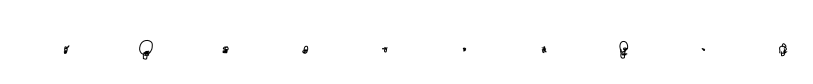

INFO:tensorflow:validation, step: 42000, loss: -0.6205, xy_loss: -0.8112, pen_loss: 0.1907, time_taken: 0.74
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 42000, loss: -0.6230, xy_loss: -0.8134, pen_loss: 0.1905, time_taken: 0.87
INFO:tensorflow:step: 42020, learning_rate: 0.0000, loss: -0.6406, xy_loss: -0.8300, pen_loss: 0.1894, time_taken: 2.39
INFO:tensorflow:step: 42040, learning_rate: 0.0000, loss: -0.6248, xy_loss: -0.8158, pen_loss: 0.1910, time_taken: 1.49
INFO:tensorflow:step: 42060, learning_rate: 0.0000, loss: -0.6201, xy_loss: -0.8093, pen_loss: 0.1892, time_taken: 1.50
INFO:tensorflow:step: 42080, learning_rate: 0.0000, loss: -0.6113, xy_loss: -0.7966, pen_loss: 0.1853, time_taken: 1.50
INFO:tensorflow:step: 42100, learning_rate: 0.0000, loss: -0.6289, xy_loss: -0.8184, pen_loss: 0.1895, time_taken: 1.50
INFO:tensorflow:step: 42120, learning_rate: 0.0000, loss: -0.6324, xy_loss: -0.8238, pen_loss: 0.1914, time_taken:

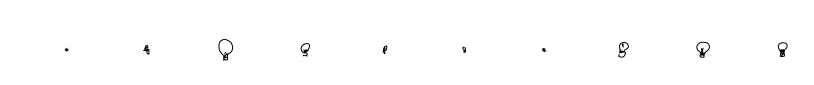

INFO:tensorflow:step: 43020, learning_rate: 0.0000, loss: -0.6336, xy_loss: -0.8214, pen_loss: 0.1878, time_taken: 3.87
INFO:tensorflow:step: 43040, learning_rate: 0.0000, loss: -0.6338, xy_loss: -0.8185, pen_loss: 0.1847, time_taken: 1.50
INFO:tensorflow:step: 43060, learning_rate: 0.0000, loss: -0.6337, xy_loss: -0.8220, pen_loss: 0.1883, time_taken: 1.50
INFO:tensorflow:step: 43080, learning_rate: 0.0000, loss: -0.6464, xy_loss: -0.8339, pen_loss: 0.1875, time_taken: 1.52
INFO:tensorflow:step: 43100, learning_rate: 0.0000, loss: -0.6246, xy_loss: -0.8108, pen_loss: 0.1862, time_taken: 1.52
INFO:tensorflow:step: 43120, learning_rate: 0.0000, loss: -0.6338, xy_loss: -0.8210, pen_loss: 0.1871, time_taken: 1.53
INFO:tensorflow:step: 43140, learning_rate: 0.0000, loss: -0.6368, xy_loss: -0.8245, pen_loss: 0.1876, time_taken: 1.51
INFO:tensorflow:step: 43160, learning_rate: 0.0000, loss: -0.6209, xy_loss: -0.8093, pen_loss: 0.1884, time_taken: 1.51
INFO:tensorflow:step: 43180, learning_ra

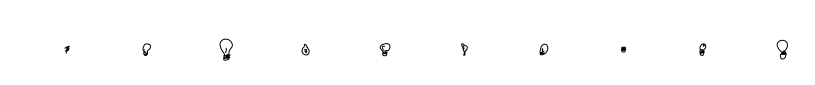

INFO:tensorflow:validation, step: 44000, loss: -0.6417, xy_loss: -0.8294, pen_loss: 0.1876, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 44000, loss: -0.6449, xy_loss: -0.8322, pen_loss: 0.1873, time_taken: 0.87
INFO:tensorflow:step: 44020, learning_rate: 0.0000, loss: -0.6461, xy_loss: -0.8309, pen_loss: 0.1848, time_taken: 2.35
INFO:tensorflow:step: 44040, learning_rate: 0.0000, loss: -0.6291, xy_loss: -0.8159, pen_loss: 0.1868, time_taken: 1.53
INFO:tensorflow:step: 44060, learning_rate: 0.0000, loss: -0.6404, xy_loss: -0.8252, pen_loss: 0.1849, time_taken: 1.50
INFO:tensorflow:step: 44080, learning_rate: 0.0000, loss: -0.6408, xy_loss: -0.8257, pen_loss: 0.1849, time_taken: 1.49
INFO:tensorflow:step: 44100, learning_rate: 0.0000, loss: -0.6572, xy_loss: -0.8454, pen_loss: 0.1882, time_taken: 1.50
INFO:tensorflow:step: 44120, learning_rate: 0.0000, loss: -0.6549, xy_loss: -0.8418, pen_loss: 0.1869, time_taken:

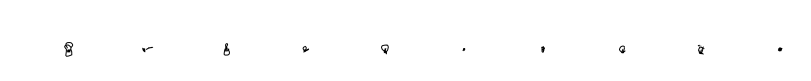

INFO:tensorflow:step: 45020, learning_rate: 0.0000, loss: -0.6312, xy_loss: -0.8175, pen_loss: 0.1863, time_taken: 4.49
INFO:tensorflow:step: 45040, learning_rate: 0.0000, loss: -0.6502, xy_loss: -0.8349, pen_loss: 0.1847, time_taken: 1.52
INFO:tensorflow:step: 45060, learning_rate: 0.0000, loss: -0.6539, xy_loss: -0.8379, pen_loss: 0.1840, time_taken: 1.52
INFO:tensorflow:step: 45080, learning_rate: 0.0000, loss: -0.6498, xy_loss: -0.8334, pen_loss: 0.1836, time_taken: 1.52
INFO:tensorflow:step: 45100, learning_rate: 0.0000, loss: -0.6630, xy_loss: -0.8491, pen_loss: 0.1861, time_taken: 1.51
INFO:tensorflow:step: 45120, learning_rate: 0.0000, loss: -0.6539, xy_loss: -0.8391, pen_loss: 0.1852, time_taken: 1.55
INFO:tensorflow:step: 45140, learning_rate: 0.0000, loss: -0.6606, xy_loss: -0.8456, pen_loss: 0.1850, time_taken: 1.53
INFO:tensorflow:step: 45160, learning_rate: 0.0000, loss: -0.6589, xy_loss: -0.8424, pen_loss: 0.1835, time_taken: 1.51
INFO:tensorflow:step: 45180, learning_ra

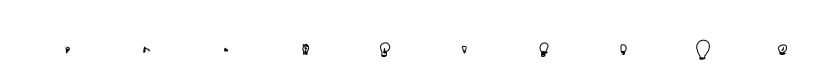

INFO:tensorflow:validation, step: 46000, loss: -0.6621, xy_loss: -0.8467, pen_loss: 0.1846, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 46000, loss: -0.6649, xy_loss: -0.8493, pen_loss: 0.1843, time_taken: 0.87
INFO:tensorflow:step: 46020, learning_rate: 0.0000, loss: -0.6643, xy_loss: -0.8459, pen_loss: 0.1817, time_taken: 2.40
INFO:tensorflow:step: 46040, learning_rate: 0.0000, loss: -0.6736, xy_loss: -0.8582, pen_loss: 0.1847, time_taken: 1.53
INFO:tensorflow:step: 46060, learning_rate: 0.0000, loss: -0.6672, xy_loss: -0.8513, pen_loss: 0.1841, time_taken: 1.51
INFO:tensorflow:step: 46080, learning_rate: 0.0000, loss: -0.6740, xy_loss: -0.8583, pen_loss: 0.1842, time_taken: 1.50
INFO:tensorflow:step: 46100, learning_rate: 0.0000, loss: -0.6594, xy_loss: -0.8418, pen_loss: 0.1823, time_taken: 1.50
INFO:tensorflow:step: 46120, learning_rate: 0.0000, loss: -0.6680, xy_loss: -0.8527, pen_loss: 0.1846, time_taken:

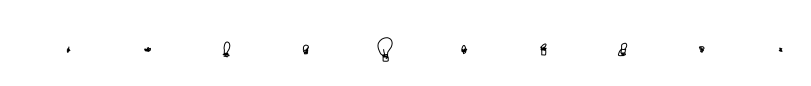

INFO:tensorflow:step: 47020, learning_rate: 0.0000, loss: -0.6628, xy_loss: -0.8453, pen_loss: 0.1825, time_taken: 4.42
INFO:tensorflow:step: 47040, learning_rate: 0.0000, loss: -0.6840, xy_loss: -0.8667, pen_loss: 0.1827, time_taken: 1.53
INFO:tensorflow:step: 47060, learning_rate: 0.0000, loss: -0.6810, xy_loss: -0.8640, pen_loss: 0.1829, time_taken: 1.53
INFO:tensorflow:step: 47080, learning_rate: 0.0000, loss: -0.6734, xy_loss: -0.8549, pen_loss: 0.1815, time_taken: 1.51
INFO:tensorflow:step: 47100, learning_rate: 0.0000, loss: -0.6876, xy_loss: -0.8693, pen_loss: 0.1817, time_taken: 1.52
INFO:tensorflow:step: 47120, learning_rate: 0.0000, loss: -0.6757, xy_loss: -0.8570, pen_loss: 0.1814, time_taken: 1.51
INFO:tensorflow:step: 47140, learning_rate: 0.0000, loss: -0.6510, xy_loss: -0.8349, pen_loss: 0.1839, time_taken: 1.54
INFO:tensorflow:step: 47160, learning_rate: 0.0000, loss: -0.6801, xy_loss: -0.8632, pen_loss: 0.1830, time_taken: 1.50
INFO:tensorflow:step: 47180, learning_ra

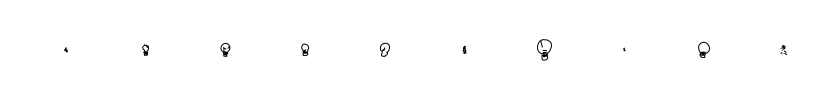

INFO:tensorflow:validation, step: 48000, loss: -0.6820, xy_loss: -0.8639, pen_loss: 0.1819, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 48000, loss: -0.6847, xy_loss: -0.8663, pen_loss: 0.1816, time_taken: 0.87
INFO:tensorflow:step: 48020, learning_rate: 0.0000, loss: -0.6893, xy_loss: -0.8698, pen_loss: 0.1806, time_taken: 2.39
INFO:tensorflow:step: 48040, learning_rate: 0.0000, loss: -0.6862, xy_loss: -0.8682, pen_loss: 0.1820, time_taken: 1.63
INFO:tensorflow:step: 48060, learning_rate: 0.0000, loss: -0.6883, xy_loss: -0.8693, pen_loss: 0.1810, time_taken: 1.51
INFO:tensorflow:step: 48080, learning_rate: 0.0000, loss: -0.6872, xy_loss: -0.8684, pen_loss: 0.1812, time_taken: 1.54
INFO:tensorflow:step: 48100, learning_rate: 0.0000, loss: -0.6878, xy_loss: -0.8696, pen_loss: 0.1818, time_taken: 1.53
INFO:tensorflow:step: 48120, learning_rate: 0.0000, loss: -0.7018, xy_loss: -0.8833, pen_loss: 0.1815, time_taken:

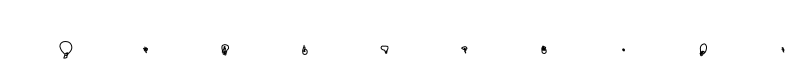

INFO:tensorflow:step: 49020, learning_rate: 0.0000, loss: -0.6989, xy_loss: -0.8786, pen_loss: 0.1797, time_taken: 4.46
INFO:tensorflow:step: 49040, learning_rate: 0.0000, loss: -0.7012, xy_loss: -0.8799, pen_loss: 0.1787, time_taken: 1.50
INFO:tensorflow:step: 49060, learning_rate: 0.0000, loss: -0.6937, xy_loss: -0.8719, pen_loss: 0.1782, time_taken: 1.51
INFO:tensorflow:step: 49080, learning_rate: 0.0000, loss: -0.6842, xy_loss: -0.8657, pen_loss: 0.1815, time_taken: 1.62
INFO:tensorflow:step: 49100, learning_rate: 0.0000, loss: -0.6918, xy_loss: -0.8733, pen_loss: 0.1815, time_taken: 1.52
INFO:tensorflow:step: 49120, learning_rate: 0.0000, loss: -0.6898, xy_loss: -0.8695, pen_loss: 0.1797, time_taken: 1.51
INFO:tensorflow:step: 49140, learning_rate: 0.0000, loss: -0.7251, xy_loss: -0.9039, pen_loss: 0.1788, time_taken: 1.52
INFO:tensorflow:step: 49160, learning_rate: 0.0000, loss: -0.7016, xy_loss: -0.8815, pen_loss: 0.1800, time_taken: 1.50
INFO:tensorflow:step: 49180, learning_ra

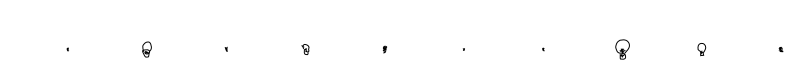

INFO:tensorflow:validation, step: 50000, loss: -0.7015, xy_loss: -0.8807, pen_loss: 0.1792, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 50000, loss: -0.7042, xy_loss: -0.8831, pen_loss: 0.1789, time_taken: 0.88
INFO:tensorflow:step: 50020, learning_rate: 0.0000, loss: -0.7125, xy_loss: -0.8916, pen_loss: 0.1791, time_taken: 2.40
INFO:tensorflow:step: 50040, learning_rate: 0.0000, loss: -0.7028, xy_loss: -0.8801, pen_loss: 0.1773, time_taken: 1.52
INFO:tensorflow:step: 50060, learning_rate: 0.0000, loss: -0.7057, xy_loss: -0.8860, pen_loss: 0.1803, time_taken: 1.52
INFO:tensorflow:step: 50080, learning_rate: 0.0000, loss: -0.6985, xy_loss: -0.8744, pen_loss: 0.1759, time_taken: 1.53
INFO:tensorflow:step: 50100, learning_rate: 0.0000, loss: -0.6972, xy_loss: -0.8758, pen_loss: 0.1787, time_taken: 1.54
INFO:tensorflow:step: 50120, learning_rate: 0.0000, loss: -0.6976, xy_loss: -0.8752, pen_loss: 0.1775, time_taken:

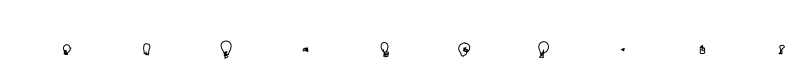

INFO:tensorflow:step: 51020, learning_rate: 0.0000, loss: -0.7281, xy_loss: -0.9063, pen_loss: 0.1781, time_taken: 4.64
INFO:tensorflow:step: 51040, learning_rate: 0.0000, loss: -0.7210, xy_loss: -0.8985, pen_loss: 0.1775, time_taken: 1.52
INFO:tensorflow:step: 51060, learning_rate: 0.0000, loss: -0.7135, xy_loss: -0.8900, pen_loss: 0.1765, time_taken: 1.50
INFO:tensorflow:step: 51080, learning_rate: 0.0000, loss: -0.7133, xy_loss: -0.8896, pen_loss: 0.1762, time_taken: 1.55
INFO:tensorflow:step: 51100, learning_rate: 0.0000, loss: -0.7245, xy_loss: -0.9030, pen_loss: 0.1786, time_taken: 1.53
INFO:tensorflow:step: 51120, learning_rate: 0.0000, loss: -0.7116, xy_loss: -0.8902, pen_loss: 0.1786, time_taken: 1.51
INFO:tensorflow:step: 51140, learning_rate: 0.0000, loss: -0.7259, xy_loss: -0.9016, pen_loss: 0.1757, time_taken: 1.52
INFO:tensorflow:step: 51160, learning_rate: 0.0000, loss: -0.7097, xy_loss: -0.8850, pen_loss: 0.1754, time_taken: 1.63
INFO:tensorflow:step: 51180, learning_ra

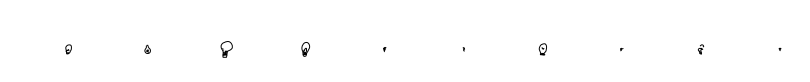

INFO:tensorflow:validation, step: 52000, loss: -0.7216, xy_loss: -0.8983, pen_loss: 0.1766, time_taken: 0.76
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 52000, loss: -0.7237, xy_loss: -0.9001, pen_loss: 0.1764, time_taken: 0.87
INFO:tensorflow:step: 52020, learning_rate: 0.0000, loss: -0.7183, xy_loss: -0.8939, pen_loss: 0.1756, time_taken: 2.36
INFO:tensorflow:step: 52040, learning_rate: 0.0000, loss: -0.7455, xy_loss: -0.9206, pen_loss: 0.1751, time_taken: 1.50
INFO:tensorflow:step: 52060, learning_rate: 0.0000, loss: -0.7509, xy_loss: -0.9261, pen_loss: 0.1753, time_taken: 1.54
INFO:tensorflow:step: 52080, learning_rate: 0.0000, loss: -0.7314, xy_loss: -0.9059, pen_loss: 0.1745, time_taken: 1.49
INFO:tensorflow:step: 52100, learning_rate: 0.0000, loss: -0.7191, xy_loss: -0.8947, pen_loss: 0.1756, time_taken: 1.52
INFO:tensorflow:step: 52120, learning_rate: 0.0000, loss: -0.7228, xy_loss: -0.8991, pen_loss: 0.1763, time_taken:

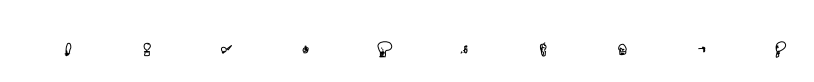

INFO:tensorflow:step: 53020, learning_rate: 0.0000, loss: -0.7407, xy_loss: -0.9177, pen_loss: 0.1769, time_taken: 5.40
INFO:tensorflow:step: 53040, learning_rate: 0.0000, loss: -0.7422, xy_loss: -0.9182, pen_loss: 0.1761, time_taken: 1.50
INFO:tensorflow:step: 53060, learning_rate: 0.0000, loss: -0.7559, xy_loss: -0.9321, pen_loss: 0.1762, time_taken: 1.52
INFO:tensorflow:step: 53080, learning_rate: 0.0000, loss: -0.7349, xy_loss: -0.9076, pen_loss: 0.1726, time_taken: 1.51
INFO:tensorflow:step: 53100, learning_rate: 0.0000, loss: -0.7427, xy_loss: -0.9186, pen_loss: 0.1759, time_taken: 1.51
INFO:tensorflow:step: 53120, learning_rate: 0.0000, loss: -0.7328, xy_loss: -0.9061, pen_loss: 0.1733, time_taken: 1.51
INFO:tensorflow:step: 53140, learning_rate: 0.0000, loss: -0.7413, xy_loss: -0.9150, pen_loss: 0.1737, time_taken: 1.53
INFO:tensorflow:step: 53160, learning_rate: 0.0000, loss: -0.7222, xy_loss: -0.8973, pen_loss: 0.1751, time_taken: 1.53
INFO:tensorflow:step: 53180, learning_ra

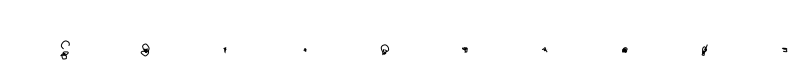

INFO:tensorflow:validation, step: 54000, loss: -0.7387, xy_loss: -0.9130, pen_loss: 0.1743, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 54000, loss: -0.7410, xy_loss: -0.9150, pen_loss: 0.1740, time_taken: 0.87
INFO:tensorflow:step: 54020, learning_rate: 0.0000, loss: -0.7405, xy_loss: -0.9138, pen_loss: 0.1733, time_taken: 2.37
INFO:tensorflow:step: 54040, learning_rate: 0.0000, loss: -0.7363, xy_loss: -0.9094, pen_loss: 0.1731, time_taken: 1.52
INFO:tensorflow:step: 54060, learning_rate: 0.0000, loss: -0.7359, xy_loss: -0.9079, pen_loss: 0.1720, time_taken: 1.52
INFO:tensorflow:step: 54080, learning_rate: 0.0000, loss: -0.7184, xy_loss: -0.8913, pen_loss: 0.1729, time_taken: 1.53
INFO:tensorflow:step: 54100, learning_rate: 0.0000, loss: -0.7275, xy_loss: -0.8995, pen_loss: 0.1721, time_taken: 1.53
INFO:tensorflow:step: 54120, learning_rate: 0.0000, loss: -0.7395, xy_loss: -0.9123, pen_loss: 0.1728, time_taken:

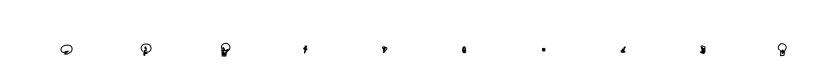

INFO:tensorflow:step: 55020, learning_rate: 0.0000, loss: -0.7549, xy_loss: -0.9273, pen_loss: 0.1725, time_taken: 4.84
INFO:tensorflow:step: 55040, learning_rate: 0.0000, loss: -0.7626, xy_loss: -0.9344, pen_loss: 0.1718, time_taken: 1.53
INFO:tensorflow:step: 55060, learning_rate: 0.0000, loss: -0.7353, xy_loss: -0.9031, pen_loss: 0.1678, time_taken: 1.54
INFO:tensorflow:step: 55080, learning_rate: 0.0000, loss: -0.7569, xy_loss: -0.9287, pen_loss: 0.1718, time_taken: 1.52
INFO:tensorflow:step: 55100, learning_rate: 0.0000, loss: -0.7495, xy_loss: -0.9213, pen_loss: 0.1718, time_taken: 1.52
INFO:tensorflow:step: 55120, learning_rate: 0.0000, loss: -0.7570, xy_loss: -0.9307, pen_loss: 0.1736, time_taken: 1.52
INFO:tensorflow:step: 55140, learning_rate: 0.0000, loss: -0.7549, xy_loss: -0.9260, pen_loss: 0.1712, time_taken: 1.52
INFO:tensorflow:step: 55160, learning_rate: 0.0000, loss: -0.7510, xy_loss: -0.9210, pen_loss: 0.1700, time_taken: 1.51
INFO:tensorflow:step: 55180, learning_ra

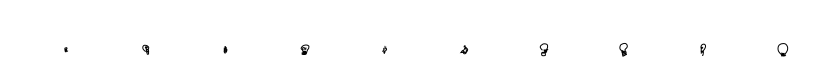

INFO:tensorflow:validation, step: 56000, loss: -0.7577, xy_loss: -0.9296, pen_loss: 0.1718, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 56000, loss: -0.7603, xy_loss: -0.9320, pen_loss: 0.1716, time_taken: 0.87
INFO:tensorflow:step: 56020, learning_rate: 0.0000, loss: -0.7697, xy_loss: -0.9423, pen_loss: 0.1725, time_taken: 2.41
INFO:tensorflow:step: 56040, learning_rate: 0.0000, loss: -0.7566, xy_loss: -0.9307, pen_loss: 0.1741, time_taken: 1.51
INFO:tensorflow:step: 56060, learning_rate: 0.0000, loss: -0.7648, xy_loss: -0.9357, pen_loss: 0.1708, time_taken: 1.51
INFO:tensorflow:step: 56080, learning_rate: 0.0000, loss: -0.7631, xy_loss: -0.9341, pen_loss: 0.1710, time_taken: 1.51
INFO:tensorflow:step: 56100, learning_rate: 0.0000, loss: -0.7541, xy_loss: -0.9249, pen_loss: 0.1708, time_taken: 1.52
INFO:tensorflow:step: 56120, learning_rate: 0.0000, loss: -0.7692, xy_loss: -0.9406, pen_loss: 0.1714, time_taken:

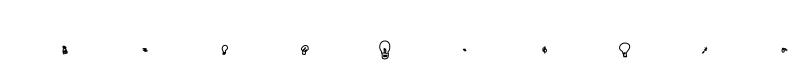

INFO:tensorflow:step: 57020, learning_rate: 0.0000, loss: -0.7817, xy_loss: -0.9520, pen_loss: 0.1703, time_taken: 4.90
INFO:tensorflow:step: 57040, learning_rate: 0.0000, loss: -0.7896, xy_loss: -0.9610, pen_loss: 0.1714, time_taken: 1.52
INFO:tensorflow:step: 57060, learning_rate: 0.0000, loss: -0.7586, xy_loss: -0.9257, pen_loss: 0.1670, time_taken: 1.52
INFO:tensorflow:step: 57080, learning_rate: 0.0000, loss: -0.7863, xy_loss: -0.9567, pen_loss: 0.1704, time_taken: 1.51
INFO:tensorflow:step: 57100, learning_rate: 0.0000, loss: -0.7619, xy_loss: -0.9310, pen_loss: 0.1691, time_taken: 1.53
INFO:tensorflow:step: 57120, learning_rate: 0.0000, loss: -0.7792, xy_loss: -0.9499, pen_loss: 0.1707, time_taken: 1.51
INFO:tensorflow:step: 57140, learning_rate: 0.0000, loss: -0.7602, xy_loss: -0.9268, pen_loss: 0.1666, time_taken: 1.51
INFO:tensorflow:step: 57160, learning_rate: 0.0000, loss: -0.7662, xy_loss: -0.9362, pen_loss: 0.1700, time_taken: 1.50
INFO:tensorflow:step: 57180, learning_ra

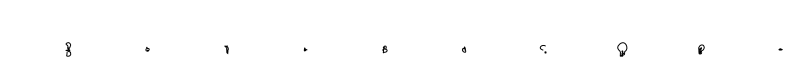

INFO:tensorflow:validation, step: 58000, loss: -0.7771, xy_loss: -0.9467, pen_loss: 0.1696, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 58000, loss: -0.7800, xy_loss: -0.9494, pen_loss: 0.1694, time_taken: 0.87
INFO:tensorflow:step: 58020, learning_rate: 0.0000, loss: -0.7997, xy_loss: -0.9693, pen_loss: 0.1696, time_taken: 2.39
INFO:tensorflow:step: 58040, learning_rate: 0.0000, loss: -0.7849, xy_loss: -0.9557, pen_loss: 0.1708, time_taken: 1.52
INFO:tensorflow:step: 58060, learning_rate: 0.0000, loss: -0.8000, xy_loss: -0.9700, pen_loss: 0.1701, time_taken: 1.50
INFO:tensorflow:step: 58080, learning_rate: 0.0000, loss: -0.7833, xy_loss: -0.9541, pen_loss: 0.1708, time_taken: 1.53
INFO:tensorflow:step: 58100, learning_rate: 0.0000, loss: -0.7904, xy_loss: -0.9619, pen_loss: 0.1714, time_taken: 1.50
INFO:tensorflow:step: 58120, learning_rate: 0.0000, loss: -0.7765, xy_loss: -0.9463, pen_loss: 0.1698, time_taken:

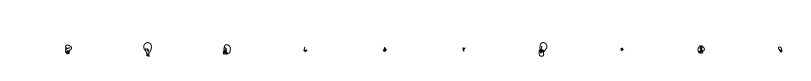

INFO:tensorflow:step: 59020, learning_rate: 0.0000, loss: -0.7890, xy_loss: -0.9550, pen_loss: 0.1660, time_taken: 4.80
INFO:tensorflow:step: 59040, learning_rate: 0.0000, loss: -0.8144, xy_loss: -0.9839, pen_loss: 0.1695, time_taken: 1.54
INFO:tensorflow:step: 59060, learning_rate: 0.0000, loss: -0.7875, xy_loss: -0.9548, pen_loss: 0.1673, time_taken: 1.51
INFO:tensorflow:step: 59080, learning_rate: 0.0000, loss: -0.8001, xy_loss: -0.9694, pen_loss: 0.1692, time_taken: 1.51
INFO:tensorflow:step: 59100, learning_rate: 0.0000, loss: -0.7903, xy_loss: -0.9590, pen_loss: 0.1687, time_taken: 1.53
INFO:tensorflow:step: 59120, learning_rate: 0.0000, loss: -0.7929, xy_loss: -0.9624, pen_loss: 0.1695, time_taken: 1.54
INFO:tensorflow:step: 59140, learning_rate: 0.0000, loss: -0.7904, xy_loss: -0.9571, pen_loss: 0.1667, time_taken: 1.53
INFO:tensorflow:step: 59160, learning_rate: 0.0000, loss: -0.7809, xy_loss: -0.9466, pen_loss: 0.1656, time_taken: 1.52
INFO:tensorflow:step: 59180, learning_ra

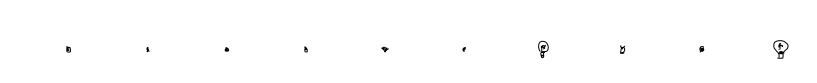

INFO:tensorflow:validation, step: 60000, loss: -0.7946, xy_loss: -0.9621, pen_loss: 0.1675, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 60000, loss: -0.7971, xy_loss: -0.9644, pen_loss: 0.1673, time_taken: 0.87
INFO:tensorflow:step: 60020, learning_rate: 0.0000, loss: -0.7926, xy_loss: -0.9587, pen_loss: 0.1660, time_taken: 2.38
INFO:tensorflow:step: 60040, learning_rate: 0.0000, loss: -0.8020, xy_loss: -0.9693, pen_loss: 0.1673, time_taken: 1.53
INFO:tensorflow:step: 60060, learning_rate: 0.0000, loss: -0.7999, xy_loss: -0.9673, pen_loss: 0.1674, time_taken: 1.49
INFO:tensorflow:step: 60080, learning_rate: 0.0000, loss: -0.8093, xy_loss: -0.9769, pen_loss: 0.1675, time_taken: 1.52
INFO:tensorflow:step: 60100, learning_rate: 0.0000, loss: -0.7901, xy_loss: -0.9565, pen_loss: 0.1663, time_taken: 1.52
INFO:tensorflow:step: 60120, learning_rate: 0.0000, loss: -0.8096, xy_loss: -0.9772, pen_loss: 0.1675, time_taken:

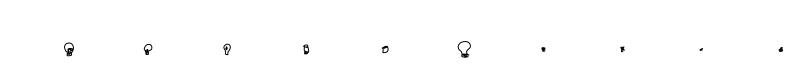

INFO:tensorflow:step: 61020, learning_rate: 0.0000, loss: -0.8128, xy_loss: -0.9792, pen_loss: 0.1664, time_taken: 4.96
INFO:tensorflow:step: 61040, learning_rate: 0.0000, loss: -0.8014, xy_loss: -0.9652, pen_loss: 0.1638, time_taken: 1.54
INFO:tensorflow:step: 61060, learning_rate: 0.0000, loss: -0.8182, xy_loss: -0.9840, pen_loss: 0.1659, time_taken: 1.50
INFO:tensorflow:step: 61080, learning_rate: 0.0000, loss: -0.8201, xy_loss: -0.9869, pen_loss: 0.1668, time_taken: 1.54
INFO:tensorflow:step: 61100, learning_rate: 0.0000, loss: -0.8194, xy_loss: -0.9855, pen_loss: 0.1661, time_taken: 1.51
INFO:tensorflow:step: 61120, learning_rate: 0.0000, loss: -0.8153, xy_loss: -0.9806, pen_loss: 0.1653, time_taken: 1.50
INFO:tensorflow:step: 61140, learning_rate: 0.0000, loss: -0.8089, xy_loss: -0.9762, pen_loss: 0.1673, time_taken: 1.52
INFO:tensorflow:step: 61160, learning_rate: 0.0000, loss: -0.8164, xy_loss: -0.9839, pen_loss: 0.1675, time_taken: 1.50
INFO:tensorflow:step: 61180, learning_ra

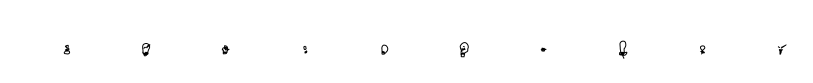

INFO:tensorflow:validation, step: 62000, loss: -0.8137, xy_loss: -0.9791, pen_loss: 0.1655, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 62000, loss: -0.8160, xy_loss: -0.9812, pen_loss: 0.1653, time_taken: 0.88
INFO:tensorflow:step: 62020, learning_rate: 0.0000, loss: -0.8125, xy_loss: -0.9761, pen_loss: 0.1637, time_taken: 2.41
INFO:tensorflow:step: 62040, learning_rate: 0.0000, loss: -0.8243, xy_loss: -0.9890, pen_loss: 0.1647, time_taken: 1.50
INFO:tensorflow:step: 62060, learning_rate: 0.0000, loss: -0.8142, xy_loss: -0.9788, pen_loss: 0.1645, time_taken: 1.52
INFO:tensorflow:step: 62080, learning_rate: 0.0000, loss: -0.8105, xy_loss: -0.9742, pen_loss: 0.1637, time_taken: 1.54
INFO:tensorflow:step: 62100, learning_rate: 0.0000, loss: -0.8156, xy_loss: -0.9782, pen_loss: 0.1626, time_taken: 1.50
INFO:tensorflow:step: 62120, learning_rate: 0.0000, loss: -0.8264, xy_loss: -0.9908, pen_loss: 0.1644, time_taken:

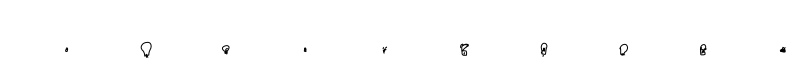

INFO:tensorflow:step: 63020, learning_rate: 0.0000, loss: -0.8279, xy_loss: -0.9931, pen_loss: 0.1652, time_taken: 4.32
INFO:tensorflow:step: 63040, learning_rate: 0.0000, loss: -0.8150, xy_loss: -0.9799, pen_loss: 0.1649, time_taken: 1.51
INFO:tensorflow:step: 63060, learning_rate: 0.0000, loss: -0.8431, xy_loss: -1.0062, pen_loss: 0.1631, time_taken: 1.55
INFO:tensorflow:step: 63080, learning_rate: 0.0000, loss: -0.8309, xy_loss: -0.9954, pen_loss: 0.1645, time_taken: 1.50
INFO:tensorflow:step: 63100, learning_rate: 0.0000, loss: -0.8212, xy_loss: -0.9845, pen_loss: 0.1633, time_taken: 1.50
INFO:tensorflow:step: 63120, learning_rate: 0.0000, loss: -0.8458, xy_loss: -1.0106, pen_loss: 0.1648, time_taken: 1.52
INFO:tensorflow:step: 63140, learning_rate: 0.0000, loss: -0.8375, xy_loss: -1.0030, pen_loss: 0.1655, time_taken: 1.53
INFO:tensorflow:step: 63160, learning_rate: 0.0000, loss: -0.8194, xy_loss: -0.9835, pen_loss: 0.1641, time_taken: 1.52
INFO:tensorflow:step: 63180, learning_ra

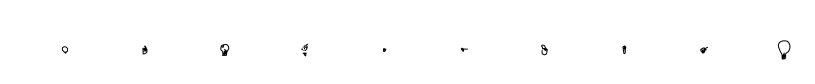

INFO:tensorflow:validation, step: 64000, loss: -0.8312, xy_loss: -0.9947, pen_loss: 0.1635, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 64000, loss: -0.8337, xy_loss: -0.9971, pen_loss: 0.1634, time_taken: 0.89
INFO:tensorflow:step: 64020, learning_rate: 0.0000, loss: -0.8486, xy_loss: -1.0137, pen_loss: 0.1651, time_taken: 2.44
INFO:tensorflow:step: 64040, learning_rate: 0.0000, loss: -0.8465, xy_loss: -1.0117, pen_loss: 0.1652, time_taken: 1.52
INFO:tensorflow:step: 64060, learning_rate: 0.0000, loss: -0.8407, xy_loss: -1.0040, pen_loss: 0.1633, time_taken: 1.52
INFO:tensorflow:step: 64080, learning_rate: 0.0000, loss: -0.8423, xy_loss: -1.0055, pen_loss: 0.1632, time_taken: 1.55
INFO:tensorflow:step: 64100, learning_rate: 0.0000, loss: -0.8401, xy_loss: -1.0048, pen_loss: 0.1647, time_taken: 1.48
INFO:tensorflow:step: 64120, learning_rate: 0.0000, loss: -0.8286, xy_loss: -0.9892, pen_loss: 0.1606, time_taken:

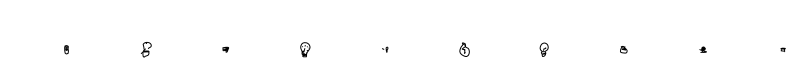

INFO:tensorflow:step: 65020, learning_rate: 0.0000, loss: -0.8450, xy_loss: -1.0059, pen_loss: 0.1609, time_taken: 4.52
INFO:tensorflow:step: 65040, learning_rate: 0.0000, loss: -0.8392, xy_loss: -1.0014, pen_loss: 0.1622, time_taken: 1.52
INFO:tensorflow:step: 65060, learning_rate: 0.0000, loss: -0.8403, xy_loss: -1.0004, pen_loss: 0.1601, time_taken: 1.56
INFO:tensorflow:step: 65080, learning_rate: 0.0000, loss: -0.8481, xy_loss: -1.0119, pen_loss: 0.1638, time_taken: 1.53
INFO:tensorflow:step: 65100, learning_rate: 0.0000, loss: -0.8390, xy_loss: -1.0003, pen_loss: 0.1613, time_taken: 1.54
INFO:tensorflow:step: 65120, learning_rate: 0.0000, loss: -0.8385, xy_loss: -1.0004, pen_loss: 0.1619, time_taken: 1.52
INFO:tensorflow:step: 65140, learning_rate: 0.0000, loss: -0.8487, xy_loss: -1.0095, pen_loss: 0.1608, time_taken: 1.51
INFO:tensorflow:step: 65160, learning_rate: 0.0000, loss: -0.8485, xy_loss: -1.0097, pen_loss: 0.1612, time_taken: 1.52
INFO:tensorflow:step: 65180, learning_ra

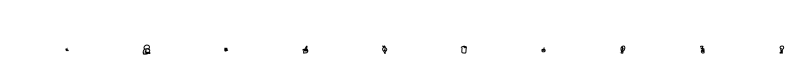

INFO:tensorflow:validation, step: 66000, loss: -0.8491, xy_loss: -1.0106, pen_loss: 0.1615, time_taken: 0.75
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 66000, loss: -0.8515, xy_loss: -1.0129, pen_loss: 0.1614, time_taken: 0.89
INFO:tensorflow:step: 66020, learning_rate: 0.0000, loss: -0.8613, xy_loss: -1.0241, pen_loss: 0.1627, time_taken: 2.39
INFO:tensorflow:step: 66040, learning_rate: 0.0000, loss: -0.8499, xy_loss: -1.0059, pen_loss: 0.1560, time_taken: 1.48
INFO:tensorflow:step: 66060, learning_rate: 0.0000, loss: -0.8464, xy_loss: -1.0069, pen_loss: 0.1605, time_taken: 1.49
INFO:tensorflow:step: 66080, learning_rate: 0.0000, loss: -0.8587, xy_loss: -1.0183, pen_loss: 0.1597, time_taken: 1.52
INFO:tensorflow:step: 66100, learning_rate: 0.0000, loss: -0.8596, xy_loss: -1.0199, pen_loss: 0.1603, time_taken: 1.52
INFO:tensorflow:step: 66120, learning_rate: 0.0000, loss: -0.8540, xy_loss: -1.0132, pen_loss: 0.1592, time_taken:

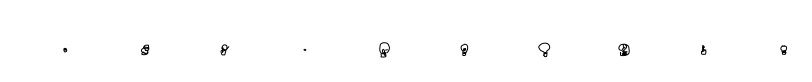

INFO:tensorflow:step: 67020, learning_rate: 0.0000, loss: -0.8753, xy_loss: -1.0356, pen_loss: 0.1603, time_taken: 4.29
INFO:tensorflow:step: 67040, learning_rate: 0.0000, loss: -0.8530, xy_loss: -1.0131, pen_loss: 0.1602, time_taken: 1.49
INFO:tensorflow:step: 67060, learning_rate: 0.0000, loss: -0.8680, xy_loss: -1.0297, pen_loss: 0.1617, time_taken: 1.50
INFO:tensorflow:step: 67080, learning_rate: 0.0000, loss: -0.8851, xy_loss: -1.0439, pen_loss: 0.1588, time_taken: 1.53
INFO:tensorflow:step: 67100, learning_rate: 0.0000, loss: -0.8902, xy_loss: -1.0521, pen_loss: 0.1618, time_taken: 1.52
INFO:tensorflow:step: 67120, learning_rate: 0.0000, loss: -0.8732, xy_loss: -1.0352, pen_loss: 0.1621, time_taken: 1.51
INFO:tensorflow:step: 67140, learning_rate: 0.0000, loss: -0.8687, xy_loss: -1.0308, pen_loss: 0.1621, time_taken: 1.52
INFO:tensorflow:step: 67160, learning_rate: 0.0000, loss: -0.8478, xy_loss: -1.0099, pen_loss: 0.1620, time_taken: 1.53
INFO:tensorflow:step: 67180, learning_ra

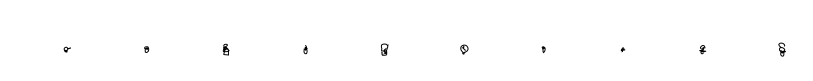

INFO:tensorflow:validation, step: 68000, loss: -0.8665, xy_loss: -1.0263, pen_loss: 0.1599, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 68000, loss: -0.8691, xy_loss: -1.0288, pen_loss: 0.1597, time_taken: 0.89
INFO:tensorflow:step: 68020, learning_rate: 0.0000, loss: -0.8554, xy_loss: -1.0136, pen_loss: 0.1582, time_taken: 2.40
INFO:tensorflow:step: 68040, learning_rate: 0.0000, loss: -0.8609, xy_loss: -1.0197, pen_loss: 0.1587, time_taken: 1.50
INFO:tensorflow:step: 68060, learning_rate: 0.0000, loss: -0.8619, xy_loss: -1.0201, pen_loss: 0.1583, time_taken: 1.53
INFO:tensorflow:step: 68080, learning_rate: 0.0000, loss: -0.8779, xy_loss: -1.0350, pen_loss: 0.1571, time_taken: 1.54
INFO:tensorflow:step: 68100, learning_rate: 0.0000, loss: -0.8861, xy_loss: -1.0451, pen_loss: 0.1590, time_taken: 1.51
INFO:tensorflow:step: 68120, learning_rate: 0.0000, loss: -0.8654, xy_loss: -1.0227, pen_loss: 0.1573, time_taken:

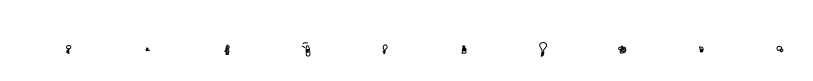

INFO:tensorflow:step: 69020, learning_rate: 0.0000, loss: -0.8911, xy_loss: -1.0503, pen_loss: 0.1591, time_taken: 4.47
INFO:tensorflow:step: 69040, learning_rate: 0.0000, loss: -0.8929, xy_loss: -1.0523, pen_loss: 0.1594, time_taken: 1.55
INFO:tensorflow:step: 69060, learning_rate: 0.0000, loss: -0.8946, xy_loss: -1.0527, pen_loss: 0.1582, time_taken: 1.56
INFO:tensorflow:step: 69080, learning_rate: 0.0000, loss: -0.8699, xy_loss: -1.0255, pen_loss: 0.1556, time_taken: 1.51
INFO:tensorflow:step: 69100, learning_rate: 0.0000, loss: -0.8976, xy_loss: -1.0550, pen_loss: 0.1574, time_taken: 1.52
INFO:tensorflow:step: 69120, learning_rate: 0.0000, loss: -0.8824, xy_loss: -1.0383, pen_loss: 0.1559, time_taken: 1.51
INFO:tensorflow:step: 69140, learning_rate: 0.0000, loss: -0.8903, xy_loss: -1.0495, pen_loss: 0.1592, time_taken: 1.51
INFO:tensorflow:step: 69160, learning_rate: 0.0000, loss: -0.8718, xy_loss: -1.0281, pen_loss: 0.1563, time_taken: 1.53
INFO:tensorflow:step: 69180, learning_ra

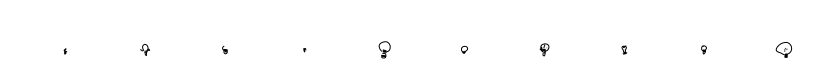

INFO:tensorflow:validation, step: 70000, loss: -0.8848, xy_loss: -1.0427, pen_loss: 0.1579, time_taken: 0.76
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 70000, loss: -0.8868, xy_loss: -1.0447, pen_loss: 0.1578, time_taken: 0.88
INFO:tensorflow:step: 70020, learning_rate: 0.0000, loss: -0.8922, xy_loss: -1.0486, pen_loss: 0.1563, time_taken: 2.40
INFO:tensorflow:step: 70040, learning_rate: 0.0000, loss: -0.8975, xy_loss: -1.0549, pen_loss: 0.1574, time_taken: 1.53
INFO:tensorflow:step: 70060, learning_rate: 0.0000, loss: -0.8825, xy_loss: -1.0403, pen_loss: 0.1577, time_taken: 1.52
INFO:tensorflow:step: 70080, learning_rate: 0.0000, loss: -0.8979, xy_loss: -1.0545, pen_loss: 0.1566, time_taken: 1.54
INFO:tensorflow:step: 70100, learning_rate: 0.0000, loss: -0.8981, xy_loss: -1.0546, pen_loss: 0.1565, time_taken: 1.49
INFO:tensorflow:step: 70120, learning_rate: 0.0000, loss: -0.8894, xy_loss: -1.0470, pen_loss: 0.1577, time_taken:

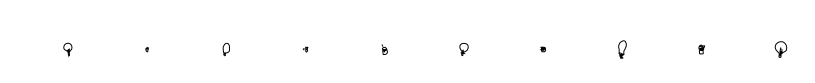

INFO:tensorflow:step: 71020, learning_rate: 0.0000, loss: -0.9074, xy_loss: -1.0631, pen_loss: 0.1557, time_taken: 4.38
INFO:tensorflow:step: 71040, learning_rate: 0.0000, loss: -0.9025, xy_loss: -1.0597, pen_loss: 0.1572, time_taken: 1.52
INFO:tensorflow:step: 71060, learning_rate: 0.0000, loss: -0.9014, xy_loss: -1.0584, pen_loss: 0.1570, time_taken: 1.50
INFO:tensorflow:step: 71080, learning_rate: 0.0000, loss: -0.9063, xy_loss: -1.0654, pen_loss: 0.1590, time_taken: 1.52
INFO:tensorflow:step: 71100, learning_rate: 0.0000, loss: -0.9052, xy_loss: -1.0628, pen_loss: 0.1576, time_taken: 1.52
INFO:tensorflow:step: 71120, learning_rate: 0.0000, loss: -0.9108, xy_loss: -1.0661, pen_loss: 0.1553, time_taken: 1.52
INFO:tensorflow:step: 71140, learning_rate: 0.0000, loss: -0.9080, xy_loss: -1.0641, pen_loss: 0.1561, time_taken: 1.51
INFO:tensorflow:step: 71160, learning_rate: 0.0000, loss: -0.9029, xy_loss: -1.0602, pen_loss: 0.1573, time_taken: 1.51
INFO:tensorflow:step: 71180, learning_ra

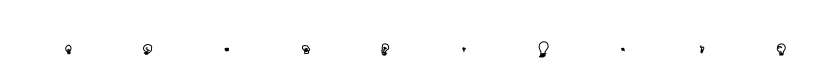

INFO:tensorflow:validation, step: 72000, loss: -0.9024, xy_loss: -1.0587, pen_loss: 0.1563, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 72000, loss: -0.9047, xy_loss: -1.0608, pen_loss: 0.1561, time_taken: 0.89
INFO:tensorflow:step: 72020, learning_rate: 0.0000, loss: -0.9045, xy_loss: -1.0594, pen_loss: 0.1549, time_taken: 2.42
INFO:tensorflow:step: 72040, learning_rate: 0.0000, loss: -0.8867, xy_loss: -1.0404, pen_loss: 0.1538, time_taken: 1.64
INFO:tensorflow:step: 72060, learning_rate: 0.0000, loss: -0.9156, xy_loss: -1.0721, pen_loss: 0.1566, time_taken: 1.50
INFO:tensorflow:step: 72080, learning_rate: 0.0000, loss: -0.9011, xy_loss: -1.0551, pen_loss: 0.1539, time_taken: 1.48
INFO:tensorflow:step: 72100, learning_rate: 0.0000, loss: -0.9070, xy_loss: -1.0614, pen_loss: 0.1545, time_taken: 1.53
INFO:tensorflow:step: 72120, learning_rate: 0.0000, loss: -0.9016, xy_loss: -1.0555, pen_loss: 0.1539, time_taken:

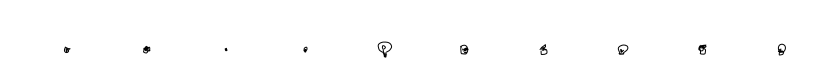

INFO:tensorflow:step: 73020, learning_rate: 0.0000, loss: -0.9068, xy_loss: -1.0594, pen_loss: 0.1526, time_taken: 4.27
INFO:tensorflow:step: 73040, learning_rate: 0.0000, loss: -0.9165, xy_loss: -1.0700, pen_loss: 0.1535, time_taken: 1.54
INFO:tensorflow:step: 73060, learning_rate: 0.0000, loss: -0.9172, xy_loss: -1.0734, pen_loss: 0.1562, time_taken: 1.52
INFO:tensorflow:step: 73080, learning_rate: 0.0000, loss: -0.9636, xy_loss: -1.1211, pen_loss: 0.1575, time_taken: 1.63
INFO:tensorflow:step: 73100, learning_rate: 0.0000, loss: -0.9202, xy_loss: -1.0765, pen_loss: 0.1563, time_taken: 1.50
INFO:tensorflow:step: 73120, learning_rate: 0.0000, loss: -0.9233, xy_loss: -1.0786, pen_loss: 0.1552, time_taken: 1.55
INFO:tensorflow:step: 73140, learning_rate: 0.0000, loss: -0.9208, xy_loss: -1.0761, pen_loss: 0.1553, time_taken: 1.50
INFO:tensorflow:step: 73160, learning_rate: 0.0000, loss: -0.9220, xy_loss: -1.0766, pen_loss: 0.1545, time_taken: 1.53
INFO:tensorflow:step: 73180, learning_ra

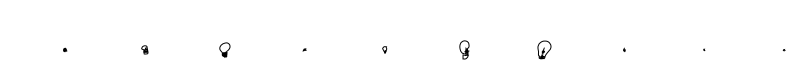

INFO:tensorflow:validation, step: 74000, loss: -0.9204, xy_loss: -1.0750, pen_loss: 0.1546, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 74000, loss: -0.9223, xy_loss: -1.0768, pen_loss: 0.1545, time_taken: 0.88
INFO:tensorflow:step: 74020, learning_rate: 0.0000, loss: -0.9242, xy_loss: -1.0798, pen_loss: 0.1556, time_taken: 2.38
INFO:tensorflow:step: 74040, learning_rate: 0.0000, loss: -0.9338, xy_loss: -1.0871, pen_loss: 0.1533, time_taken: 1.55
INFO:tensorflow:step: 74060, learning_rate: 0.0000, loss: -0.9114, xy_loss: -1.0655, pen_loss: 0.1542, time_taken: 1.50
INFO:tensorflow:step: 74080, learning_rate: 0.0000, loss: -0.9258, xy_loss: -1.0803, pen_loss: 0.1546, time_taken: 1.53
INFO:tensorflow:step: 74100, learning_rate: 0.0000, loss: -0.9319, xy_loss: -1.0842, pen_loss: 0.1523, time_taken: 1.52
INFO:tensorflow:step: 74120, learning_rate: 0.0000, loss: -0.9486, xy_loss: -1.1026, pen_loss: 0.1541, time_taken:

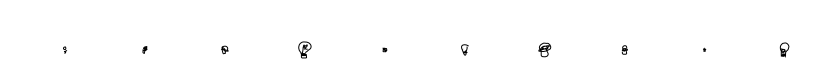

INFO:tensorflow:step: 75020, learning_rate: 0.0000, loss: -0.9242, xy_loss: -1.0728, pen_loss: 0.1486, time_taken: 4.86
INFO:tensorflow:step: 75040, learning_rate: 0.0000, loss: -0.9311, xy_loss: -1.0848, pen_loss: 0.1537, time_taken: 1.54
INFO:tensorflow:step: 75060, learning_rate: 0.0000, loss: -0.9513, xy_loss: -1.1032, pen_loss: 0.1519, time_taken: 1.50
INFO:tensorflow:step: 75080, learning_rate: 0.0000, loss: -0.9269, xy_loss: -1.0778, pen_loss: 0.1508, time_taken: 1.53
INFO:tensorflow:step: 75100, learning_rate: 0.0000, loss: -0.9299, xy_loss: -1.0805, pen_loss: 0.1506, time_taken: 1.51
INFO:tensorflow:step: 75120, learning_rate: 0.0000, loss: -0.9310, xy_loss: -1.0814, pen_loss: 0.1505, time_taken: 1.52
INFO:tensorflow:step: 75140, learning_rate: 0.0000, loss: -0.9257, xy_loss: -1.0791, pen_loss: 0.1534, time_taken: 1.52
INFO:tensorflow:step: 75160, learning_rate: 0.0000, loss: -0.9630, xy_loss: -1.1184, pen_loss: 0.1554, time_taken: 1.52
INFO:tensorflow:step: 75180, learning_ra

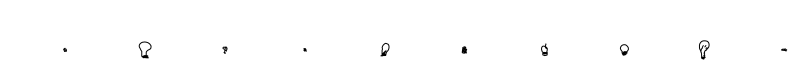

INFO:tensorflow:validation, step: 76000, loss: -0.9374, xy_loss: -1.0905, pen_loss: 0.1530, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 76000, loss: -0.9400, xy_loss: -1.0929, pen_loss: 0.1529, time_taken: 0.88
INFO:tensorflow:step: 76020, learning_rate: 0.0000, loss: -0.9460, xy_loss: -1.0966, pen_loss: 0.1506, time_taken: 2.39
INFO:tensorflow:step: 76040, learning_rate: 0.0000, loss: -0.9386, xy_loss: -1.0898, pen_loss: 0.1512, time_taken: 1.54
INFO:tensorflow:step: 76060, learning_rate: 0.0000, loss: -0.9467, xy_loss: -1.1003, pen_loss: 0.1537, time_taken: 1.51
INFO:tensorflow:step: 76080, learning_rate: 0.0000, loss: -0.9403, xy_loss: -1.0925, pen_loss: 0.1521, time_taken: 1.55
INFO:tensorflow:step: 76100, learning_rate: 0.0000, loss: -0.9575, xy_loss: -1.1107, pen_loss: 0.1532, time_taken: 1.54
INFO:tensorflow:step: 76120, learning_rate: 0.0000, loss: -0.9545, xy_loss: -1.1056, pen_loss: 0.1511, time_taken:

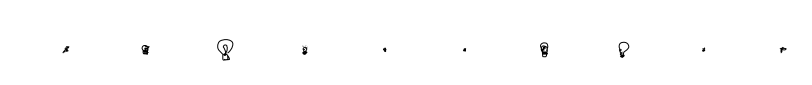

INFO:tensorflow:step: 77020, learning_rate: 0.0000, loss: -0.9516, xy_loss: -1.1034, pen_loss: 0.1518, time_taken: 4.47
INFO:tensorflow:step: 77040, learning_rate: 0.0000, loss: -0.9683, xy_loss: -1.1195, pen_loss: 0.1513, time_taken: 1.53
INFO:tensorflow:step: 77060, learning_rate: 0.0000, loss: -0.9423, xy_loss: -1.0929, pen_loss: 0.1506, time_taken: 1.52
INFO:tensorflow:step: 77080, learning_rate: 0.0000, loss: -0.9629, xy_loss: -1.1136, pen_loss: 0.1507, time_taken: 1.52
INFO:tensorflow:step: 77100, learning_rate: 0.0000, loss: -0.9688, xy_loss: -1.1217, pen_loss: 0.1529, time_taken: 1.54
INFO:tensorflow:step: 77120, learning_rate: 0.0000, loss: -0.9539, xy_loss: -1.1050, pen_loss: 0.1512, time_taken: 1.52
INFO:tensorflow:step: 77140, learning_rate: 0.0000, loss: -0.9391, xy_loss: -1.0904, pen_loss: 0.1513, time_taken: 1.49
INFO:tensorflow:step: 77160, learning_rate: 0.0000, loss: -0.9456, xy_loss: -1.0966, pen_loss: 0.1510, time_taken: 1.50
INFO:tensorflow:step: 77180, learning_ra

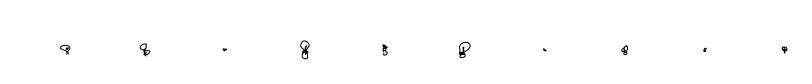

INFO:tensorflow:validation, step: 78000, loss: -0.9526, xy_loss: -1.1042, pen_loss: 0.1516, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 78000, loss: -0.9547, xy_loss: -1.1061, pen_loss: 0.1514, time_taken: 1.12
INFO:tensorflow:step: 78020, learning_rate: 0.0000, loss: -0.9603, xy_loss: -1.1102, pen_loss: 0.1499, time_taken: 2.65
INFO:tensorflow:step: 78040, learning_rate: 0.0000, loss: -0.9600, xy_loss: -1.1112, pen_loss: 0.1512, time_taken: 1.51
INFO:tensorflow:step: 78060, learning_rate: 0.0000, loss: -0.9664, xy_loss: -1.1173, pen_loss: 0.1509, time_taken: 1.53
INFO:tensorflow:step: 78080, learning_rate: 0.0000, loss: -0.9616, xy_loss: -1.1131, pen_loss: 0.1515, time_taken: 1.54
INFO:tensorflow:step: 78100, learning_rate: 0.0000, loss: -0.9734, xy_loss: -1.1250, pen_loss: 0.1516, time_taken: 1.49
INFO:tensorflow:step: 78120, learning_rate: 0.0000, loss: -0.9608, xy_loss: -1.1099, pen_loss: 0.1491, time_taken:

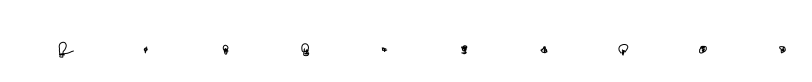

INFO:tensorflow:step: 79020, learning_rate: 0.0000, loss: -0.9784, xy_loss: -1.1259, pen_loss: 0.1474, time_taken: 4.32
INFO:tensorflow:step: 79040, learning_rate: 0.0000, loss: -0.9790, xy_loss: -1.1292, pen_loss: 0.1503, time_taken: 1.51
INFO:tensorflow:step: 79060, learning_rate: 0.0000, loss: -0.9628, xy_loss: -1.1144, pen_loss: 0.1516, time_taken: 1.52
INFO:tensorflow:step: 79080, learning_rate: 0.0000, loss: -0.9631, xy_loss: -1.1140, pen_loss: 0.1508, time_taken: 1.51
INFO:tensorflow:step: 79100, learning_rate: 0.0000, loss: -0.9694, xy_loss: -1.1189, pen_loss: 0.1494, time_taken: 1.52
INFO:tensorflow:step: 79120, learning_rate: 0.0000, loss: -0.9826, xy_loss: -1.1341, pen_loss: 0.1515, time_taken: 1.53
INFO:tensorflow:step: 79140, learning_rate: 0.0000, loss: -0.9715, xy_loss: -1.1222, pen_loss: 0.1507, time_taken: 1.51
INFO:tensorflow:step: 79160, learning_rate: 0.0000, loss: -0.9711, xy_loss: -1.1189, pen_loss: 0.1478, time_taken: 1.52
INFO:tensorflow:step: 79180, learning_ra

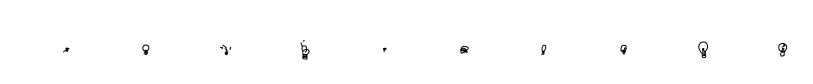

INFO:tensorflow:validation, step: 80000, loss: -0.9722, xy_loss: -1.1223, pen_loss: 0.1500, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 80000, loss: -0.9741, xy_loss: -1.1240, pen_loss: 0.1499, time_taken: 0.88
INFO:tensorflow:step: 80020, learning_rate: 0.0000, loss: -0.9820, xy_loss: -1.1296, pen_loss: 0.1476, time_taken: 2.38
INFO:tensorflow:step: 80040, learning_rate: 0.0000, loss: -0.9847, xy_loss: -1.1345, pen_loss: 0.1498, time_taken: 1.53
INFO:tensorflow:step: 80060, learning_rate: 0.0000, loss: -0.9800, xy_loss: -1.1289, pen_loss: 0.1490, time_taken: 1.54
INFO:tensorflow:step: 80080, learning_rate: 0.0000, loss: -0.9779, xy_loss: -1.1271, pen_loss: 0.1492, time_taken: 1.51
INFO:tensorflow:step: 80100, learning_rate: 0.0000, loss: -0.9843, xy_loss: -1.1347, pen_loss: 0.1504, time_taken: 1.52
INFO:tensorflow:step: 80120, learning_rate: 0.0000, loss: -0.9874, xy_loss: -1.1382, pen_loss: 0.1508, time_taken:

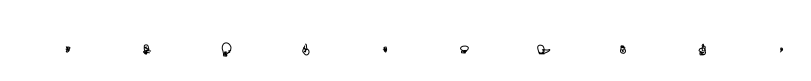

INFO:tensorflow:step: 81020, learning_rate: 0.0000, loss: -0.9902, xy_loss: -1.1404, pen_loss: 0.1502, time_taken: 4.90
INFO:tensorflow:step: 81040, learning_rate: 0.0000, loss: -0.9925, xy_loss: -1.1412, pen_loss: 0.1487, time_taken: 1.52
INFO:tensorflow:step: 81060, learning_rate: 0.0000, loss: -0.9811, xy_loss: -1.1287, pen_loss: 0.1476, time_taken: 1.53
INFO:tensorflow:step: 81080, learning_rate: 0.0000, loss: -0.9899, xy_loss: -1.1402, pen_loss: 0.1503, time_taken: 1.52
INFO:tensorflow:step: 81100, learning_rate: 0.0000, loss: -0.9842, xy_loss: -1.1326, pen_loss: 0.1484, time_taken: 1.51
INFO:tensorflow:step: 81120, learning_rate: 0.0000, loss: -0.9762, xy_loss: -1.1246, pen_loss: 0.1484, time_taken: 1.53
INFO:tensorflow:step: 81140, learning_rate: 0.0000, loss: -0.9793, xy_loss: -1.1269, pen_loss: 0.1476, time_taken: 1.52
INFO:tensorflow:step: 81160, learning_rate: 0.0000, loss: -0.9861, xy_loss: -1.1326, pen_loss: 0.1465, time_taken: 1.50
INFO:tensorflow:step: 81180, learning_ra

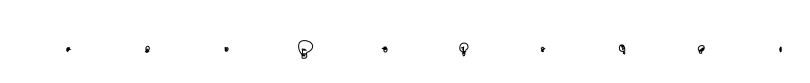

INFO:tensorflow:validation, step: 82000, loss: -0.9884, xy_loss: -1.1370, pen_loss: 0.1486, time_taken: 0.79
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 82000, loss: -0.9912, xy_loss: -1.1397, pen_loss: 0.1485, time_taken: 0.88
INFO:tensorflow:step: 82020, learning_rate: 0.0000, loss: -0.9959, xy_loss: -1.1431, pen_loss: 0.1472, time_taken: 2.41
INFO:tensorflow:step: 82040, learning_rate: 0.0000, loss: -0.9910, xy_loss: -1.1379, pen_loss: 0.1469, time_taken: 1.52
INFO:tensorflow:step: 82060, learning_rate: 0.0000, loss: -1.0026, xy_loss: -1.1513, pen_loss: 0.1486, time_taken: 1.51
INFO:tensorflow:step: 82080, learning_rate: 0.0000, loss: -0.9849, xy_loss: -1.1294, pen_loss: 0.1445, time_taken: 1.51
INFO:tensorflow:step: 82100, learning_rate: 0.0000, loss: -1.0020, xy_loss: -1.1494, pen_loss: 0.1474, time_taken: 1.51
INFO:tensorflow:step: 82120, learning_rate: 0.0000, loss: -1.0011, xy_loss: -1.1514, pen_loss: 0.1502, time_taken:

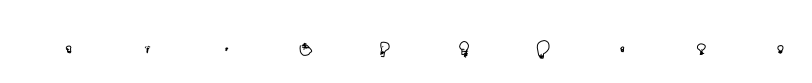

INFO:tensorflow:step: 83020, learning_rate: 0.0000, loss: -0.9976, xy_loss: -1.1456, pen_loss: 0.1480, time_taken: 4.32
INFO:tensorflow:step: 83040, learning_rate: 0.0000, loss: -1.0090, xy_loss: -1.1560, pen_loss: 0.1469, time_taken: 1.54
INFO:tensorflow:step: 83060, learning_rate: 0.0000, loss: -1.0122, xy_loss: -1.1588, pen_loss: 0.1467, time_taken: 1.53
INFO:tensorflow:step: 83080, learning_rate: 0.0000, loss: -1.0009, xy_loss: -1.1498, pen_loss: 0.1488, time_taken: 1.50
INFO:tensorflow:step: 83100, learning_rate: 0.0000, loss: -1.0091, xy_loss: -1.1560, pen_loss: 0.1469, time_taken: 1.51
INFO:tensorflow:step: 83120, learning_rate: 0.0000, loss: -1.0000, xy_loss: -1.1444, pen_loss: 0.1444, time_taken: 1.52
INFO:tensorflow:step: 83140, learning_rate: 0.0000, loss: -1.0010, xy_loss: -1.1466, pen_loss: 0.1456, time_taken: 1.51
INFO:tensorflow:step: 83160, learning_rate: 0.0000, loss: -1.0081, xy_loss: -1.1552, pen_loss: 0.1470, time_taken: 1.54
INFO:tensorflow:step: 83180, learning_ra

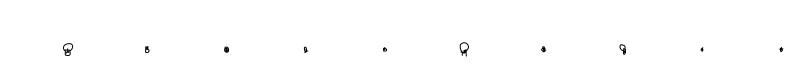

INFO:tensorflow:validation, step: 84000, loss: -1.0051, xy_loss: -1.1523, pen_loss: 0.1472, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 84000, loss: -1.0082, xy_loss: -1.1553, pen_loss: 0.1471, time_taken: 0.90
INFO:tensorflow:step: 84020, learning_rate: 0.0000, loss: -1.0179, xy_loss: -1.1633, pen_loss: 0.1454, time_taken: 2.44
INFO:tensorflow:step: 84040, learning_rate: 0.0000, loss: -1.0088, xy_loss: -1.1552, pen_loss: 0.1464, time_taken: 1.54
INFO:tensorflow:step: 84060, learning_rate: 0.0000, loss: -1.0253, xy_loss: -1.1740, pen_loss: 0.1487, time_taken: 1.51
INFO:tensorflow:step: 84080, learning_rate: 0.0000, loss: -1.0015, xy_loss: -1.1481, pen_loss: 0.1467, time_taken: 1.52
INFO:tensorflow:step: 84100, learning_rate: 0.0000, loss: -1.0280, xy_loss: -1.1763, pen_loss: 0.1483, time_taken: 1.53
INFO:tensorflow:step: 84120, learning_rate: 0.0000, loss: -0.9998, xy_loss: -1.1431, pen_loss: 0.1433, time_taken:

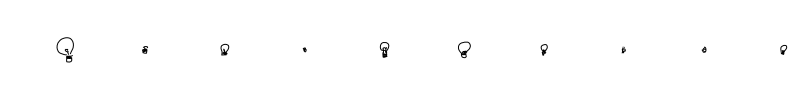

INFO:tensorflow:step: 85020, learning_rate: 0.0000, loss: -1.0262, xy_loss: -1.1728, pen_loss: 0.1465, time_taken: 4.40
INFO:tensorflow:step: 85040, learning_rate: 0.0000, loss: -1.0270, xy_loss: -1.1711, pen_loss: 0.1441, time_taken: 1.51
INFO:tensorflow:step: 85060, learning_rate: 0.0000, loss: -1.0215, xy_loss: -1.1661, pen_loss: 0.1446, time_taken: 1.54
INFO:tensorflow:step: 85080, learning_rate: 0.0000, loss: -1.0178, xy_loss: -1.1638, pen_loss: 0.1460, time_taken: 1.49
INFO:tensorflow:step: 85100, learning_rate: 0.0000, loss: -1.0346, xy_loss: -1.1832, pen_loss: 0.1487, time_taken: 1.51
INFO:tensorflow:step: 85120, learning_rate: 0.0000, loss: -1.0202, xy_loss: -1.1681, pen_loss: 0.1479, time_taken: 1.50
INFO:tensorflow:step: 85140, learning_rate: 0.0000, loss: -1.0342, xy_loss: -1.1799, pen_loss: 0.1457, time_taken: 1.51
INFO:tensorflow:step: 85160, learning_rate: 0.0000, loss: -1.0228, xy_loss: -1.1671, pen_loss: 0.1443, time_taken: 1.53
INFO:tensorflow:step: 85180, learning_ra

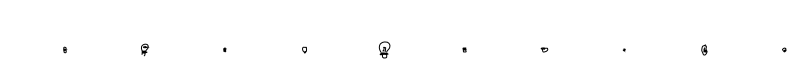

INFO:tensorflow:validation, step: 86000, loss: -1.0233, xy_loss: -1.1692, pen_loss: 0.1459, time_taken: 0.76
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 86000, loss: -1.0256, xy_loss: -1.1715, pen_loss: 0.1459, time_taken: 0.90
INFO:tensorflow:step: 86020, learning_rate: 0.0000, loss: -1.0291, xy_loss: -1.1749, pen_loss: 0.1458, time_taken: 2.43
INFO:tensorflow:step: 86040, learning_rate: 0.0000, loss: -1.0160, xy_loss: -1.1587, pen_loss: 0.1427, time_taken: 1.54
INFO:tensorflow:step: 86060, learning_rate: 0.0000, loss: -1.0325, xy_loss: -1.1775, pen_loss: 0.1450, time_taken: 1.53
INFO:tensorflow:step: 86080, learning_rate: 0.0000, loss: -1.0335, xy_loss: -1.1769, pen_loss: 0.1433, time_taken: 1.51
INFO:tensorflow:step: 86100, learning_rate: 0.0000, loss: -1.0369, xy_loss: -1.1826, pen_loss: 0.1458, time_taken: 1.52
INFO:tensorflow:step: 86120, learning_rate: 0.0000, loss: -1.0347, xy_loss: -1.1778, pen_loss: 0.1432, time_taken:

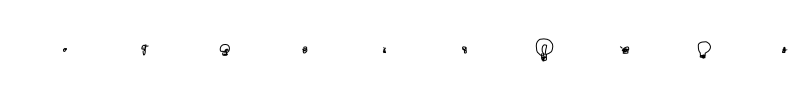

INFO:tensorflow:step: 87020, learning_rate: 0.0000, loss: -1.0267, xy_loss: -1.1728, pen_loss: 0.1461, time_taken: 4.79
INFO:tensorflow:step: 87040, learning_rate: 0.0000, loss: -1.0479, xy_loss: -1.1930, pen_loss: 0.1451, time_taken: 1.53
INFO:tensorflow:step: 87060, learning_rate: 0.0000, loss: -1.0431, xy_loss: -1.1885, pen_loss: 0.1455, time_taken: 1.51
INFO:tensorflow:step: 87080, learning_rate: 0.0000, loss: -1.0464, xy_loss: -1.1893, pen_loss: 0.1429, time_taken: 1.53
INFO:tensorflow:step: 87100, learning_rate: 0.0000, loss: -1.0435, xy_loss: -1.1874, pen_loss: 0.1439, time_taken: 1.54
INFO:tensorflow:step: 87120, learning_rate: 0.0000, loss: -1.0415, xy_loss: -1.1884, pen_loss: 0.1469, time_taken: 1.50
INFO:tensorflow:step: 87140, learning_rate: 0.0000, loss: -1.0424, xy_loss: -1.1866, pen_loss: 0.1442, time_taken: 1.53
INFO:tensorflow:step: 87160, learning_rate: 0.0000, loss: -1.0404, xy_loss: -1.1863, pen_loss: 0.1459, time_taken: 1.51
INFO:tensorflow:step: 87180, learning_ra

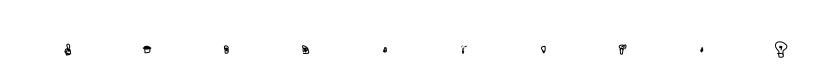

INFO:tensorflow:validation, step: 88000, loss: -1.0408, xy_loss: -1.1855, pen_loss: 0.1447, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 88000, loss: -1.0430, xy_loss: -1.1876, pen_loss: 0.1447, time_taken: 0.90
INFO:tensorflow:step: 88020, learning_rate: 0.0000, loss: -1.0324, xy_loss: -1.1759, pen_loss: 0.1435, time_taken: 2.42
INFO:tensorflow:step: 88040, learning_rate: 0.0000, loss: -1.0342, xy_loss: -1.1771, pen_loss: 0.1430, time_taken: 1.53
INFO:tensorflow:step: 88060, learning_rate: 0.0000, loss: -1.0625, xy_loss: -1.2033, pen_loss: 0.1409, time_taken: 1.51
INFO:tensorflow:step: 88080, learning_rate: 0.0000, loss: -1.0570, xy_loss: -1.2021, pen_loss: 0.1451, time_taken: 1.52
INFO:tensorflow:step: 88100, learning_rate: 0.0000, loss: -1.0513, xy_loss: -1.1951, pen_loss: 0.1438, time_taken: 1.52
INFO:tensorflow:step: 88120, learning_rate: 0.0000, loss: -1.0310, xy_loss: -1.1742, pen_loss: 0.1432, time_taken:

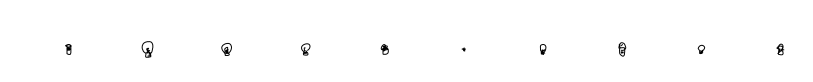

INFO:tensorflow:step: 89020, learning_rate: 0.0000, loss: -1.0600, xy_loss: -1.2063, pen_loss: 0.1464, time_taken: 4.95
INFO:tensorflow:step: 89040, learning_rate: 0.0000, loss: -1.0505, xy_loss: -1.1943, pen_loss: 0.1439, time_taken: 1.54
INFO:tensorflow:step: 89060, learning_rate: 0.0000, loss: -1.0582, xy_loss: -1.2012, pen_loss: 0.1431, time_taken: 1.51
INFO:tensorflow:step: 89080, learning_rate: 0.0000, loss: -1.0626, xy_loss: -1.2064, pen_loss: 0.1438, time_taken: 1.53
INFO:tensorflow:step: 89100, learning_rate: 0.0000, loss: -1.0459, xy_loss: -1.1857, pen_loss: 0.1398, time_taken: 1.50
INFO:tensorflow:step: 89120, learning_rate: 0.0000, loss: -1.0625, xy_loss: -1.2052, pen_loss: 0.1427, time_taken: 1.52
INFO:tensorflow:step: 89140, learning_rate: 0.0000, loss: -1.0547, xy_loss: -1.1953, pen_loss: 0.1405, time_taken: 1.53
INFO:tensorflow:step: 89160, learning_rate: 0.0000, loss: -1.0481, xy_loss: -1.1910, pen_loss: 0.1429, time_taken: 1.51
INFO:tensorflow:step: 89180, learning_ra

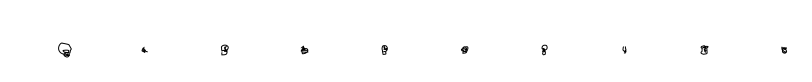

INFO:tensorflow:validation, step: 90000, loss: -1.0577, xy_loss: -1.2011, pen_loss: 0.1435, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 90000, loss: -1.0594, xy_loss: -1.2029, pen_loss: 0.1434, time_taken: 0.90
INFO:tensorflow:step: 90020, learning_rate: 0.0000, loss: -1.0565, xy_loss: -1.1957, pen_loss: 0.1392, time_taken: 2.41
INFO:tensorflow:step: 90040, learning_rate: 0.0000, loss: -1.0545, xy_loss: -1.1956, pen_loss: 0.1411, time_taken: 1.53
INFO:tensorflow:step: 90060, learning_rate: 0.0000, loss: -1.0623, xy_loss: -1.2017, pen_loss: 0.1394, time_taken: 1.53
INFO:tensorflow:step: 90080, learning_rate: 0.0000, loss: -1.0705, xy_loss: -1.2134, pen_loss: 0.1429, time_taken: 1.52
INFO:tensorflow:step: 90100, learning_rate: 0.0000, loss: -1.0887, xy_loss: -1.2356, pen_loss: 0.1469, time_taken: 1.53
INFO:tensorflow:step: 90120, learning_rate: 0.0000, loss: -1.0659, xy_loss: -1.2063, pen_loss: 0.1405, time_taken:

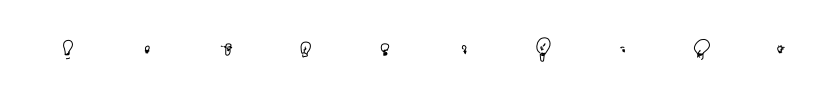

INFO:tensorflow:step: 91020, learning_rate: 0.0000, loss: -1.0603, xy_loss: -1.2000, pen_loss: 0.1397, time_taken: 3.97
INFO:tensorflow:step: 91040, learning_rate: 0.0000, loss: -1.0770, xy_loss: -1.2208, pen_loss: 0.1438, time_taken: 1.50
INFO:tensorflow:step: 91060, learning_rate: 0.0000, loss: -1.0676, xy_loss: -1.2090, pen_loss: 0.1414, time_taken: 1.51
INFO:tensorflow:step: 91080, learning_rate: 0.0000, loss: -1.0666, xy_loss: -1.2069, pen_loss: 0.1403, time_taken: 1.52
INFO:tensorflow:step: 91100, learning_rate: 0.0000, loss: -1.0838, xy_loss: -1.2268, pen_loss: 0.1430, time_taken: 1.51
INFO:tensorflow:step: 91120, learning_rate: 0.0000, loss: -1.0763, xy_loss: -1.2193, pen_loss: 0.1430, time_taken: 1.50
INFO:tensorflow:step: 91140, learning_rate: 0.0000, loss: -1.0805, xy_loss: -1.2233, pen_loss: 0.1428, time_taken: 1.53
INFO:tensorflow:step: 91160, learning_rate: 0.0000, loss: -1.0786, xy_loss: -1.2212, pen_loss: 0.1426, time_taken: 1.53
INFO:tensorflow:step: 91180, learning_ra

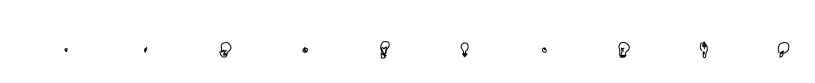

INFO:tensorflow:validation, step: 92000, loss: -1.0739, xy_loss: -1.2161, pen_loss: 0.1422, time_taken: 0.78
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 92000, loss: -1.0763, xy_loss: -1.2185, pen_loss: 0.1422, time_taken: 0.90
INFO:tensorflow:step: 92020, learning_rate: 0.0000, loss: -1.0862, xy_loss: -1.2293, pen_loss: 0.1432, time_taken: 2.44
INFO:tensorflow:step: 92040, learning_rate: 0.0000, loss: -1.0643, xy_loss: -1.2043, pen_loss: 0.1401, time_taken: 1.53
INFO:tensorflow:step: 92060, learning_rate: 0.0000, loss: -1.0811, xy_loss: -1.2223, pen_loss: 0.1412, time_taken: 1.55
INFO:tensorflow:step: 92080, learning_rate: 0.0000, loss: -1.0753, xy_loss: -1.2152, pen_loss: 0.1399, time_taken: 1.49
INFO:tensorflow:step: 92100, learning_rate: 0.0000, loss: -1.0846, xy_loss: -1.2267, pen_loss: 0.1421, time_taken: 1.51
INFO:tensorflow:step: 92120, learning_rate: 0.0000, loss: -1.0848, xy_loss: -1.2266, pen_loss: 0.1418, time_taken:

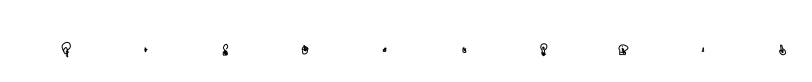

INFO:tensorflow:step: 93020, learning_rate: 0.0000, loss: -1.0832, xy_loss: -1.2244, pen_loss: 0.1412, time_taken: 4.42
INFO:tensorflow:step: 93040, learning_rate: 0.0000, loss: -1.1046, xy_loss: -1.2447, pen_loss: 0.1401, time_taken: 1.53
INFO:tensorflow:step: 93060, learning_rate: 0.0000, loss: -1.0977, xy_loss: -1.2375, pen_loss: 0.1398, time_taken: 1.49
INFO:tensorflow:step: 93080, learning_rate: 0.0000, loss: -1.0894, xy_loss: -1.2306, pen_loss: 0.1412, time_taken: 1.50
INFO:tensorflow:step: 93100, learning_rate: 0.0000, loss: -1.0712, xy_loss: -1.2093, pen_loss: 0.1381, time_taken: 1.51
INFO:tensorflow:step: 93120, learning_rate: 0.0000, loss: -1.0805, xy_loss: -1.2213, pen_loss: 0.1408, time_taken: 1.52
INFO:tensorflow:step: 93140, learning_rate: 0.0000, loss: -1.0970, xy_loss: -1.2380, pen_loss: 0.1410, time_taken: 1.52
INFO:tensorflow:step: 93160, learning_rate: 0.0000, loss: -1.1005, xy_loss: -1.2424, pen_loss: 0.1419, time_taken: 1.53
INFO:tensorflow:step: 93180, learning_ra

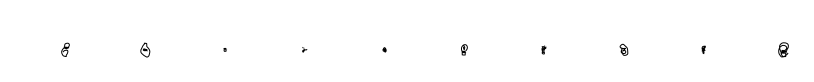

INFO:tensorflow:validation, step: 94000, loss: -1.0928, xy_loss: -1.2339, pen_loss: 0.1411, time_taken: 0.77
INFO:tensorflow:model save to ./checkpoints_v2/team-31-bulb-microphone
INFO:tensorflow:testing, step: 94000, loss: -1.0950, xy_loss: -1.2361, pen_loss: 0.1411, time_taken: 0.91
INFO:tensorflow:step: 94020, learning_rate: 0.0000, loss: -1.0968, xy_loss: -1.2339, pen_loss: 0.1371, time_taken: 2.44
INFO:tensorflow:step: 94040, learning_rate: 0.0000, loss: -1.0815, xy_loss: -1.2211, pen_loss: 0.1396, time_taken: 1.55
INFO:tensorflow:step: 94060, learning_rate: 0.0000, loss: -1.1053, xy_loss: -1.2477, pen_loss: 0.1424, time_taken: 1.53
INFO:tensorflow:step: 94080, learning_rate: 0.0000, loss: -1.1055, xy_loss: -1.2468, pen_loss: 0.1413, time_taken: 1.53
INFO:tensorflow:step: 94100, learning_rate: 0.0000, loss: -1.0829, xy_loss: -1.2221, pen_loss: 0.1392, time_taken: 1.51
INFO:tensorflow:step: 94120, learning_rate: 0.0000, loss: -1.1113, xy_loss: -1.2516, pen_loss: 0.1403, time_taken:

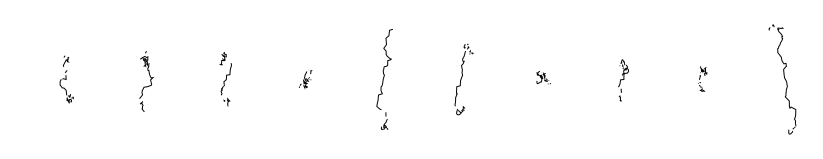

INFO:tensorflow:step: 95020, learning_rate: 0.0000, loss: -0.5129, xy_loss: -0.8134, pen_loss: 0.3005, time_taken: 4.65
INFO:tensorflow:step: 95040, learning_rate: 0.0000, loss: -0.5285, xy_loss: -0.8142, pen_loss: 0.2856, time_taken: 1.51
INFO:tensorflow:step: 95060, learning_rate: 0.0000, loss: -0.5548, xy_loss: -0.8366, pen_loss: 0.2818, time_taken: 1.50
INFO:tensorflow:step: 95080, learning_rate: 0.0000, loss: -0.5462, xy_loss: -0.8285, pen_loss: 0.2822, time_taken: 1.50
INFO:tensorflow:step: 95100, learning_rate: 0.0000, loss: -0.5366, xy_loss: -0.8256, pen_loss: 0.2891, time_taken: 1.52
INFO:tensorflow:step: 95120, learning_rate: 0.0000, loss: -0.5270, xy_loss: -0.8265, pen_loss: 0.2995, time_taken: 1.52
INFO:tensorflow:step: 95140, learning_rate: 0.0000, loss: -0.5187, xy_loss: -0.8369, pen_loss: 0.3182, time_taken: 1.50
INFO:tensorflow:step: 95160, learning_rate: 0.0000, loss: -0.4970, xy_loss: -0.8262, pen_loss: 0.3292, time_taken: 1.51
INFO:tensorflow:step: 95180, learning_ra

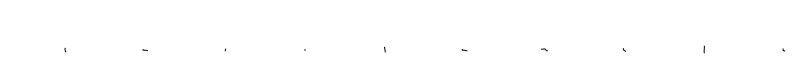

INFO:tensorflow:validation, step: 96000, loss: -0.1029, xy_loss: -0.8175, pen_loss: 0.7146, time_taken: 0.75
INFO:tensorflow:step: 96020, learning_rate: 0.0000, loss: -0.1071, xy_loss: -0.8171, pen_loss: 0.7100, time_taken: 1.50
INFO:tensorflow:step: 96040, learning_rate: 0.0000, loss: -0.1080, xy_loss: -0.8237, pen_loss: 0.7157, time_taken: 1.57
INFO:tensorflow:step: 96060, learning_rate: 0.0000, loss: -0.1148, xy_loss: -0.8246, pen_loss: 0.7098, time_taken: 1.67
INFO:tensorflow:step: 96080, learning_rate: 0.0000, loss: -0.1070, xy_loss: -0.8216, pen_loss: 0.7146, time_taken: 1.53
INFO:tensorflow:step: 96100, learning_rate: 0.0000, loss: -0.1129, xy_loss: -0.8163, pen_loss: 0.7034, time_taken: 1.54
INFO:tensorflow:step: 96120, learning_rate: 0.0000, loss: -0.1206, xy_loss: -0.8201, pen_loss: 0.6994, time_taken: 1.50
INFO:tensorflow:step: 96140, learning_rate: 0.0000, loss: -0.1100, xy_loss: -0.8078, pen_loss: 0.6978, time_taken: 1.49
INFO:tensorflow:step: 96160, learning_rate: 0.0000,

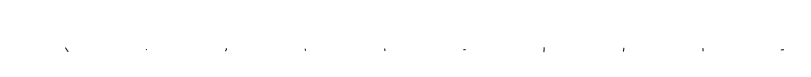

INFO:tensorflow:step: 97020, learning_rate: 0.0000, loss: -0.0052, xy_loss: -0.7767, pen_loss: 0.7715, time_taken: 1.68
INFO:tensorflow:step: 97040, learning_rate: 0.0000, loss: -0.0100, xy_loss: -0.7775, pen_loss: 0.7675, time_taken: 1.53
INFO:tensorflow:step: 97060, learning_rate: 0.0000, loss: -0.0062, xy_loss: -0.7822, pen_loss: 0.7760, time_taken: 1.56
INFO:tensorflow:step: 97080, learning_rate: 0.0000, loss: -0.0143, xy_loss: -0.7904, pen_loss: 0.7762, time_taken: 1.48
INFO:tensorflow:step: 97100, learning_rate: 0.0000, loss: -0.0068, xy_loss: -0.7861, pen_loss: 0.7793, time_taken: 1.66
INFO:tensorflow:step: 97120, learning_rate: 0.0000, loss: 0.0016, xy_loss: -0.7813, pen_loss: 0.7830, time_taken: 1.52
INFO:tensorflow:step: 97140, learning_rate: 0.0000, loss: 0.0075, xy_loss: -0.7838, pen_loss: 0.7913, time_taken: 1.51
INFO:tensorflow:step: 97160, learning_rate: 0.0000, loss: 0.0075, xy_loss: -0.7885, pen_loss: 0.7961, time_taken: 1.54
INFO:tensorflow:step: 97180, learning_rate:

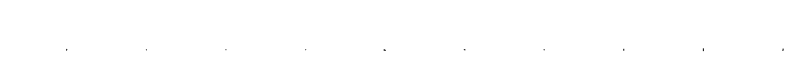

INFO:tensorflow:validation, step: 98000, loss: 0.0507, xy_loss: -0.7848, pen_loss: 0.8355, time_taken: 0.74
INFO:tensorflow:step: 98020, learning_rate: 0.0000, loss: 0.0599, xy_loss: -0.7830, pen_loss: 0.8430, time_taken: 1.51
INFO:tensorflow:step: 98040, learning_rate: 0.0000, loss: 0.0410, xy_loss: -0.7861, pen_loss: 0.8271, time_taken: 1.51
INFO:tensorflow:step: 98060, learning_rate: 0.0000, loss: 0.0451, xy_loss: -0.7822, pen_loss: 0.8272, time_taken: 1.54
INFO:tensorflow:step: 98080, learning_rate: 0.0000, loss: 0.0314, xy_loss: -0.7836, pen_loss: 0.8150, time_taken: 1.49
INFO:tensorflow:step: 98100, learning_rate: 0.0000, loss: 0.0290, xy_loss: -0.7820, pen_loss: 0.8110, time_taken: 1.53
INFO:tensorflow:step: 98120, learning_rate: 0.0000, loss: 0.0196, xy_loss: -0.7859, pen_loss: 0.8055, time_taken: 1.51
INFO:tensorflow:step: 98140, learning_rate: 0.0000, loss: 0.0210, xy_loss: -0.7918, pen_loss: 0.8128, time_taken: 1.67
INFO:tensorflow:step: 98160, learning_rate: 0.0000, loss: 0

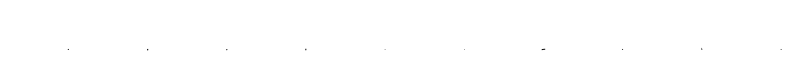

INFO:tensorflow:step: 99020, learning_rate: 0.0000, loss: -0.0091, xy_loss: -0.7380, pen_loss: 0.7289, time_taken: 1.69
INFO:tensorflow:step: 99040, learning_rate: 0.0000, loss: -0.0069, xy_loss: -0.7354, pen_loss: 0.7285, time_taken: 1.51
INFO:tensorflow:step: 99060, learning_rate: 0.0000, loss: -0.0100, xy_loss: -0.7358, pen_loss: 0.7258, time_taken: 1.51
INFO:tensorflow:step: 99080, learning_rate: 0.0000, loss: -0.0080, xy_loss: -0.7410, pen_loss: 0.7330, time_taken: 1.50
INFO:tensorflow:step: 99100, learning_rate: 0.0000, loss: -0.0084, xy_loss: -0.7390, pen_loss: 0.7306, time_taken: 1.52
INFO:tensorflow:step: 99120, learning_rate: 0.0000, loss: -0.0083, xy_loss: -0.7350, pen_loss: 0.7267, time_taken: 1.51
INFO:tensorflow:step: 99140, learning_rate: 0.0000, loss: -0.0027, xy_loss: -0.7369, pen_loss: 0.7341, time_taken: 1.52
INFO:tensorflow:step: 99160, learning_rate: 0.0000, loss: -0.0213, xy_loss: -0.7447, pen_loss: 0.7234, time_taken: 1.51
INFO:tensorflow:step: 99180, learning_ra

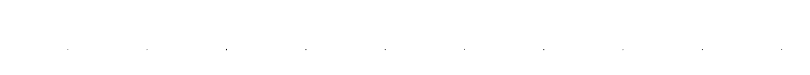

INFO:tensorflow:validation, step: 100000, loss: -0.0213, xy_loss: -0.7437, pen_loss: 0.7224, time_taken: 0.77
INFO:tensorflow:step: 100020, learning_rate: 0.0000, loss: -0.0233, xy_loss: -0.7506, pen_loss: 0.7273, time_taken: 1.50
INFO:tensorflow:step: 100040, learning_rate: 0.0000, loss: -0.0336, xy_loss: -0.7529, pen_loss: 0.7193, time_taken: 1.52
INFO:tensorflow:step: 100060, learning_rate: 0.0000, loss: -0.0212, xy_loss: -0.7439, pen_loss: 0.7227, time_taken: 1.54
INFO:tensorflow:step: 100080, learning_rate: 0.0000, loss: -0.0216, xy_loss: -0.7498, pen_loss: 0.7282, time_taken: 1.53
INFO:tensorflow:step: 100100, learning_rate: 0.0000, loss: -0.0230, xy_loss: -0.7463, pen_loss: 0.7232, time_taken: 1.54
INFO:tensorflow:step: 100120, learning_rate: 0.0000, loss: -0.0188, xy_loss: -0.7388, pen_loss: 0.7200, time_taken: 1.53
INFO:tensorflow:step: 100140, learning_rate: 0.0000, loss: -0.0285, xy_loss: -0.7549, pen_loss: 0.7264, time_taken: 1.50
INFO:tensorflow:step: 100160, learning_rate

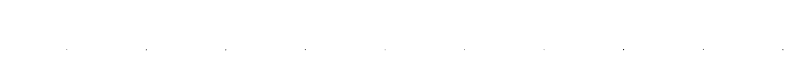

INFO:tensorflow:step: 101020, learning_rate: 0.0000, loss: -0.0455, xy_loss: -0.7610, pen_loss: 0.7155, time_taken: 1.60
INFO:tensorflow:step: 101040, learning_rate: 0.0000, loss: -0.0380, xy_loss: -0.7586, pen_loss: 0.7206, time_taken: 1.52
INFO:tensorflow:step: 101060, learning_rate: 0.0000, loss: -0.0343, xy_loss: -0.7475, pen_loss: 0.7132, time_taken: 1.52
INFO:tensorflow:step: 101080, learning_rate: 0.0000, loss: -0.0420, xy_loss: -0.7624, pen_loss: 0.7204, time_taken: 1.52
INFO:tensorflow:step: 101100, learning_rate: 0.0000, loss: -0.0325, xy_loss: -0.7607, pen_loss: 0.7282, time_taken: 1.53
INFO:tensorflow:step: 101120, learning_rate: 0.0000, loss: -0.0494, xy_loss: -0.7659, pen_loss: 0.7165, time_taken: 1.51
INFO:tensorflow:step: 101140, learning_rate: 0.0000, loss: -0.0442, xy_loss: -0.7626, pen_loss: 0.7184, time_taken: 1.53
INFO:tensorflow:step: 101160, learning_rate: 0.0000, loss: -0.0407, xy_loss: -0.7592, pen_loss: 0.7186, time_taken: 1.52
INFO:tensorflow:step: 101180, le

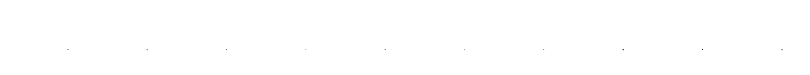

INFO:tensorflow:validation, step: 102000, loss: -0.0563, xy_loss: -0.7711, pen_loss: 0.7148, time_taken: 0.76
INFO:tensorflow:step: 102020, learning_rate: 0.0000, loss: -0.0725, xy_loss: -0.7781, pen_loss: 0.7056, time_taken: 1.51
INFO:tensorflow:step: 102040, learning_rate: 0.0000, loss: -0.0567, xy_loss: -0.7668, pen_loss: 0.7101, time_taken: 1.51
INFO:tensorflow:step: 102060, learning_rate: 0.0000, loss: -0.0560, xy_loss: -0.7699, pen_loss: 0.7139, time_taken: 1.50
INFO:tensorflow:step: 102080, learning_rate: 0.0000, loss: -0.0556, xy_loss: -0.7712, pen_loss: 0.7157, time_taken: 1.51
INFO:tensorflow:step: 102100, learning_rate: 0.0000, loss: -0.0594, xy_loss: -0.7787, pen_loss: 0.7193, time_taken: 1.51
INFO:tensorflow:step: 102120, learning_rate: 0.0000, loss: -0.0622, xy_loss: -0.7711, pen_loss: 0.7089, time_taken: 1.51
INFO:tensorflow:step: 102140, learning_rate: 0.0000, loss: -0.0565, xy_loss: -0.7680, pen_loss: 0.7116, time_taken: 1.51
INFO:tensorflow:step: 102160, learning_rate

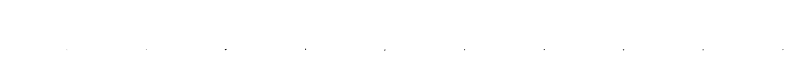

INFO:tensorflow:step: 103020, learning_rate: 0.0000, loss: -0.0751, xy_loss: -0.7847, pen_loss: 0.7096, time_taken: 1.61
INFO:tensorflow:step: 103040, learning_rate: 0.0000, loss: -0.0774, xy_loss: -0.7910, pen_loss: 0.7136, time_taken: 1.53
INFO:tensorflow:step: 103060, learning_rate: 0.0000, loss: -0.0797, xy_loss: -0.7830, pen_loss: 0.7033, time_taken: 1.50
INFO:tensorflow:step: 103080, learning_rate: 0.0000, loss: -0.0853, xy_loss: -0.7860, pen_loss: 0.7007, time_taken: 1.51
INFO:tensorflow:step: 103100, learning_rate: 0.0000, loss: -0.0764, xy_loss: -0.7787, pen_loss: 0.7024, time_taken: 1.51
INFO:tensorflow:step: 103120, learning_rate: 0.0000, loss: -0.0835, xy_loss: -0.7881, pen_loss: 0.7046, time_taken: 1.52
INFO:tensorflow:step: 103140, learning_rate: 0.0000, loss: -0.0748, xy_loss: -0.7799, pen_loss: 0.7051, time_taken: 1.53
INFO:tensorflow:step: 103160, learning_rate: 0.0000, loss: -0.0849, xy_loss: -0.7887, pen_loss: 0.7038, time_taken: 1.53
INFO:tensorflow:step: 103180, le

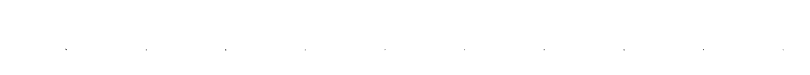

INFO:tensorflow:validation, step: 104000, loss: -0.0908, xy_loss: -0.7991, pen_loss: 0.7083, time_taken: 0.74
INFO:tensorflow:step: 104020, learning_rate: 0.0000, loss: -0.1001, xy_loss: -0.8052, pen_loss: 0.7052, time_taken: 1.52
INFO:tensorflow:step: 104040, learning_rate: 0.0000, loss: -0.0884, xy_loss: -0.7921, pen_loss: 0.7038, time_taken: 1.51
INFO:tensorflow:step: 104060, learning_rate: 0.0000, loss: -0.1005, xy_loss: -0.8047, pen_loss: 0.7042, time_taken: 1.51
INFO:tensorflow:step: 104080, learning_rate: 0.0000, loss: -0.0871, xy_loss: -0.7987, pen_loss: 0.7116, time_taken: 1.52
INFO:tensorflow:step: 104100, learning_rate: 0.0000, loss: -0.0956, xy_loss: -0.7972, pen_loss: 0.7016, time_taken: 1.51
INFO:tensorflow:step: 104120, learning_rate: 0.0000, loss: -0.0970, xy_loss: -0.8060, pen_loss: 0.7090, time_taken: 1.52
INFO:tensorflow:step: 104140, learning_rate: 0.0000, loss: -0.1063, xy_loss: -0.8091, pen_loss: 0.7028, time_taken: 1.50
INFO:tensorflow:step: 104160, learning_rate

In [17]:
model.train(sess, x_train, x_valid, x_test, num_epoch=100, batch_size=100)

In [ ]:
def render_imgs(strokes, img_size, max_seq_len):
  """ 
    convert 5-strokes format to image
        args:
            sketches: shape(data_size, max_seq_len, 5)
    """

  xy = np.cumsum(strokes[:, :, 0:2], axis=1)  # (data_size, max_seq, 2)
  min_xy = np.min(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  xy = xy - min_xy  # (data_size, max_seq, 2)
  max_xy = np.max(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  max_xy = np.where(max_xy == 0, np.ones([len(strokes), 1, 2]),
                    max_xy)  # avoid divide by 0
  xy = xy / max_xy  # (data_size, max_seq, 2)
  xy = xy * (img_size - 1)  # (data_size, max_seq, 2)

  strokes_idx = np.tile(np.arange(len(strokes))[:, None],
                        [1, img_size])  # (data_size, img_size)
  interpolate_line = np.tile(
      np.reshape(
          np.arange(img_size).astype(np.float32) / (img_size - 1),
          [1, img_size, 1]), [len(strokes), 1, 2])

  def interpolate(p1, p2):
    p1 = np.reshape(p1, [-1, 1, 2])
    p2 = np.reshape(p2, [-1, 1, 2])
    return (1 - interpolate_line
           ) * p1 + interpolate_line * p2  # (data_size, img_size, 2)

  images = np.zeros([len(strokes), img_size, img_size])
  render_next = np.ones(len(images), dtype=np.bool)
  for idx in range(max_seq_len - 1):
    p1 = xy[:, idx]
    p2 = xy[:, idx + 1]
    # if p1 is connect to p2, draw a line between them
    connect = np.where(
        np.logical_and(strokes[:, idx, 3] > strokes[:, idx, 2],
                       strokes[:, idx, 3] > strokes[:, idx, 4]),
        np.zeros(len(images), dtype=np.bool),
        np.ones(len(images), dtype=np.bool))

    p_interpolate_line = interpolate(p1, p2).astype(
        np.int32)  # (data_size, img_size, 2)
    x_idx = np.where(connect[:, None], p_interpolate_line[:, :, 0],
                     np.tile(xy[:, idx, None, 0], [1,
                                                   img_size]).astype(np.int32))
    y_idx = np.where(connect[:, None], p_interpolate_line[:, :, 1],
                     np.tile(xy[:, idx, None, 1], [1,
                                                   img_size]).astype(np.int32))
    images[strokes_idx, x_idx, y_idx] = 1
  images = np.rot90(images, -1, axes=(1, 2))
  return images

In [ ]:
class Evaluate_model:
    def __init__(self, image_size, model_name='evaluate_model', train = 1):
        self.model_name = model_name
        with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
            self.input_x = tf.placeholder(
                    tf.float32, [None, image_size, image_size], name="input_x")
            self.keep_rate = tf.placeholder(tf.float32, [], name="keep_rate")
            if train:
                self.labels = tf.placeholder(tf.float32, [None, 4], name="input_y")
                self.global_step = tf.get_variable(name='global_step', initializer=tf.constant(0), trainable=False)
            hidden = tf.reshape(self.input_x, [-1, image_size, image_size, 1])
            hidden = tf.layers.conv2d(
                    hidden,
                    filters=64,
                    kernel_size=5,
                    activation=tf.nn.relu,
                    padding='same')
            hidden = tf.nn.lrn(
                    hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
            hidden = tf.layers.conv2d(
                    hidden,
                    filters=64,
                    kernel_size=5,
                    activation=tf.nn.relu,
                    padding='same')
            hidden = tf.nn.lrn(
                    hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
            hidden = tf.layers.max_pooling2d(
                    hidden, pool_size=3, strides=2, padding='same')
            hidden = tf.layers.conv2d(
                    hidden,
                    filters=128,
                    kernel_size=5,
                    activation=tf.nn.relu,
                    padding='same')
            hidden = tf.nn.lrn(
                    hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
            hidden = tf.layers.conv2d(
                    hidden,
                    filters=128,
                    kernel_size=5,
                    activation=tf.nn.relu,
                    padding='same')
            hidden = tf.nn.lrn(
                    hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
            hidden = tf.layers.max_pooling2d(
                    hidden, pool_size=3, strides=2, padding='same')
            hidden = tf.layers.flatten(hidden)
            hidden = tf.layers.dense(hidden, 384)
            hidden = tf.layers.dense(hidden, 192)
            hidden = tf.layers.dense(hidden, 96)

            # Add dropout
            with tf.variable_scope("dropout"):
                hidden = tf.layers.dropout(hidden, 1 - self.keep_rate)
            hidden = tf.layers.dense(hidden, 4)
            # label of balloon: 0
            # label of bulb: 1
            # label of ice: 2
            # label of microphone: 3
            self.predictions = tf.nn.softmax(hidden)
            if train:
                correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                losses = tf.nn.softmax_cross_entropy_with_logits_v2(
                        logits=hidden, labels=self.labels)
                self.loss = tf.reduce_mean(losses)
                for v in tf.trainable_variables():
                    self.loss += 0.001 * tf.nn.l2_loss(v)
                # Define Training procedure
                self.lr = tf.Variable(0.001, trainable=False)
                optimizer = tf.train.AdamOptimizer(self.lr)
                grads_and_vars = optimizer.compute_gradients(
                        self.loss,
                        var_list=[v for v in tf.global_variables() if model_name in v.name])
                self.train_op = optimizer.apply_gradients(
                        grads_and_vars, global_step=self.global_step)
    
    def open_session(self):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
        self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        self.sess.run(tf.global_variables_initializer())
    
    def load_model(self):
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name + '/'))
        saver.restore(self.sess, os.path.join("checkpoints_eva", self.model_name))
    
    def save_model(self):
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'evaluate_model/'))
        saver.save(self.sess, "checkpoints_eva/evaluate_model")
    
    def train(self, x_input, y_input, epoch, dropout, batch_size):
        open_session()
        for i in range(epoch):
            print("Epoch {}".format(i))
            index = random.sample(range(0,x_input.shape[0]), k = batch_size)
            loss, _, accuracy = self.sess.run([self.loss, self.train_op, self.accuracy], feed_dict = {self.input_x : x_input[index],
                                                        self.labels : y_input[index],
                                                        self.keep_rate : dropout})
            print("loss = {:.4f}, accuracy = {:.4f}".format(loss, accuracy))
    
    def test(self, x_input, dropout):
        predict = self.sess.run(self.predictions, feed_dict = {self.input_x : x_input,
                                       self.keep_rate : dropout})
        return predict

In [ ]:
img_size = 64
eva = Evaluate_model(img_size, train = 0)
eva.open_session()
eva.load_model()
def play_game(player1, player2):
    """
    player1, player2: dict containing 12 sketch-model. 
    In your model, you need to implement *generate_stroke* function.
    """
    player1_win = 0
    player2_win = 0
    draw = 0
    generated_sketches = []
    who_draw_the_strokes = []

    THRESHOLD = 150    # if a sketch longer than threshold, stop
    for class_to_draw1 in ['balloon', 'bulb', 'ice', 'microphone']:
        for class_to_draw2 in ['balloon', 'bulb', 'ice', 'microphone']:
            if class_to_draw1 == class_to_draw2:
                continue
            dict_key1 = '{}-{}'.format(class_to_draw1, class_to_draw2)
            dict_key2 = '{}-{}'.format(class_to_draw2, class_to_draw1)

            # we will use different random seed when evaluating your model
            np.random.seed(123)
            random.seed(123)

            num_games = 100
            sketches = []    # record sketch
            results = []    # record result class
            rendered_imgs = []    # record rendered image
            who_draw_the_strokes_game = []
            for i in range(num_games):
                player1_stop = False
                player2_stop = False
                who_draw_the_stroke = []
                input_sequence = np.array([[0., 0., 1., 0., 0.]])    # start token
                turn = int(i >= 50)    # after 50 games, player2 draw first

                while len(input_sequence) < THRESHOLD:
                    if turn % 2 == 0 and not player1_stop:
                        generated_stroke = player1[dict_key1].generate_stroke(
                                sess, input_sequence)
                        try:    # if your stroke not follow rule, skip your turn
                            generated_stroke = check_stroke(generated_stroke)
                        except:
                            turn += 1
                            continue
                        who_draw_the_stroke.append(0)
                        if generated_stroke[-1][4] == 1:
                            player1_stop = True
                            generated_stroke[-1][2:] = [0., 1., 0.]
                    elif turn % 2 == 1 and not player2_stop:
                        generated_stroke = player2[dict_key2].generate_stroke(
                                sess, input_sequence)
                        try:    # if your stroke not follow rule, skip your turn
                            generated_stroke = check_stroke(generated_stroke)
                        except:
                            turn += 1
                            continue
                        who_draw_the_stroke.append(1)
                        if generated_stroke[-1][4] == 1:
                            player2_stop = True
                            generated_stroke[-1][2:] = [0., 1., 0.]
                    elif player1_stop and player2_stop:
                        input_sequence[-1][2:] = [0., 0., 1.]
                        break
                    else:
                        turn += 1
                        continue
                    input_sequence = np.concatenate(
                            [input_sequence, generated_stroke], axis=0)
                    turn += 1
                    result, rendered_img = predict(sess, eva, input_sequence, class_to_draw1, class_to_draw2)

                    # after turn 4, we check if game end
                    if turn >= 4 and result != 'draw':
                        break

                    if input_sequence[-1][4] == 1:
                        break
                results.append(result)
                sketches.append(input_sequence)
                rendered_imgs.append(rendered_img)
                who_draw_the_strokes_game.append(who_draw_the_stroke)
            # plot rendered images
            print('player1 draw {}, player2 draw {}'.format(class_to_draw1, class_to_draw2))
            fig, axs = plt.subplots(10, 10, figsize=(20, 20))
            axs = axs.flatten()
            for i in range(len(rendered_imgs)):
                axs[i].imshow(rendered_imgs[i], cmap='gray')
                axs[i].set_xticks([])
                axs[i].set_yticks([])
                axs[i].set_title(results[i])
            plt.show()
            print('In 100 games, {} of sketches look like {}, {} of sketches look like {}, {} of sketches look like others'.
                    format((np.array(results) == class_to_draw1).sum(), class_to_draw1, (
                            np.array(results) == class_to_draw2).sum(), class_to_draw2, (
                                    np.array(results) == 'draw').sum()))
            player1_win += (np.array(results) == class_to_draw1).sum()
            player2_win += (np.array(results) == class_to_draw2).sum()
            draw += (np.array(results) == 'draw').sum()
            generated_sketches.append(sketches)
            who_draw_the_strokes.append(who_draw_the_strokes_game)
    print('player1 win {} games, player2 win {} games, {} games draw'.format(
            player1_win, player2_win, draw))
    return generated_sketches, who_draw_the_strokes

In [ ]:
def predict(sess, evaluate_model, sketch, class_to_draw1, class_to_draw2):
    THRESHOLD = 0.75

    # render sketch to image
    img_size = 64
    max_seq_len = len(sketch)
    rendered_imgs = render_imgs(np.array([sketch]), img_size, max_seq_len)
    predictions = evaluate_model.test(rendered_imgs, 1.0)

    encode_dict = {
            'balloon': 0,    # label of balloon
            'bulb': 1,    # label of bulb
            'ice': 2,    # label of ice
            'microphone': 3    # label of microphone
    }
    p1 = predictions[0, encode_dict[class_to_draw1]]
    p2 = predictions[0, encode_dict[class_to_draw2]]
    if p1 > p2 and p1 > THRESHOLD:
        return class_to_draw1, rendered_imgs[0]
    elif p1 < p2 and p2 > THRESHOLD:
        return class_to_draw2, rendered_imgs[0]
    else:
        return 'draw', rendered_imgs[0]

In [ ]:
def check_stroke(stroke):
  if len(stroke) > 10:
    raise Exception
  for i in range(len(stroke) - 1):
    if (stroke[-1][2:] != [1., 0., 0.]).all() and (stroke[-1][2:] != [
        0., 1., 0.
    ]).all() and (stroke[-1][2:] != [0., 0., 1.]).all():
      raise Exception
  if (stroke[-1][2:] != [0., 1., 0.]).all() and (stroke[-1][2:] != [0., 0., 1.
                                                                   ]).all():
    raise Exception
  stroke[:, :2] = np.clip(stroke[:, :2], -1, 1)
  return stroke

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
import team_31_model as player1
hps = player1.get_default_hparams()
# load model
draw_model = {}
for class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:
  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:
    if class_to_draw == class_to_compete:
      continue
    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)
    model_name = '{}-{}'.format(
        class_to_draw, class_to_compete
    )  # please change model name to team-{team_number}-{class}-{class_to_compete}
    with tf.device('/cpu:0'):
      draw_model[dict_key] = player1.SRNN_Model(hps, model_name="team-31-" + model_name)
      draw_model[dict_key].load_model(sess, checkpoint_dir='./my_model')


In [ ]:
import ta_60_model as player2
hps = player2.get_default_hparams()
draw_model_ta_60 = {}
for class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:
  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:
    if class_to_draw == class_to_compete:
      continue
    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)
    model_name = '{}-{}-60'.format(class_to_draw, class_to_compete)
    with tf.device('/cpu:0'):
      draw_model_ta_60[dict_key] = player2.SRNN_Model(
          hps, model_name=model_name)
      draw_model_ta_60[dict_key].load_model(sess, checkpoint_dir='./ta60')

In [ ]:
result, who_draw_the_strokes = play_game(draw_model, draw_model_ta_60)